# Background

Bike sharing systems are new generation of traditional bike rentals where whole process from membership, rental and return back has become automatic. Through these systems, user is able to easily rent a bike from a particular position and return back at another position. Currently, there are about over 500 bike-sharing programs around the world which is composed of over 500 thousands bicycles. Today, there exists great interest in these systems due to their important role in traffic, environmental and health issues. 

Apart from interesting real world applications of bike sharing systems, the characteristics of data being generated by these systems make them attractive for the research. Opposed to other transport services such as bus or subway, the duration of travel, departure and arrival position is explicitly recorded in these systems. This feature turns bike sharing system into a virtual sensor network that can be used for sensing mobility in the city. Hence, it is expected that most of important events in the city could be detected via monitoring these data.

# Data-Set

Bike-sharing rental process is highly correlated to the environmental and seasonal settings. For instance, weather conditions, precipitation, day of week, season, hour of the day, etc. can affect the rental behaviors. The core data set is related to the two-year historical log corresponding to years 2011 and 2012 from Capital Bikeshare system, Washington D.C., USA which is publicly available in http://capitalbikeshare.com/system-data. We aggregated the data on two hourly and daily basis and then extracted and added the corresponding weather and seasonal information. Weather information are extracted from http://www.freemeteo.com. 

# Data Set Characterstics

Both hour.csv and day.csv have the following fields, except hr which is not available in day.csv
	
- instant: record index
- dteday : date
- season : season (1:springer, 2:summer, 3:fall, 4:winter)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- holiday : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit : 
	- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
	- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
	- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
	- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

# Basic Imports

In [2]:
import numpy as np #for numerical computations
import pandas as pd #for dataframes 

import datetime

import missingno as msno #visualizing the missing values

import matplotlib.pyplot as plt #for creating visualizations
import seaborn as sns
plt.rcParams["figure.figsize"] = "25,10"
plt.rcParams["legend.fontsize"] = 16
plt.rcParams["axes.labelsize"] = 16

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


import warnings #for ignoring the warnings
warnings.filterwarnings("ignore")

# Loading the Data

In [3]:
data_hour = pd.read_csv("hour.csv")

In [4]:
data_hour.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


# Basic Pre-Processing

In [5]:
data_hour.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
instant       17379 non-null int64
dteday        17379 non-null object
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
cnt           17379 non-null int64
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [6]:
data_hour.describe(include="all").transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
instant,17379,NaN,NaN,NaN,8690,5017.03,1,4345.5,8690,13034.5,17379
dteday,17379,731,2012-07-03,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN
season,17379,NaN,NaN,NaN,2.50164,1.10692,1,2,3,3,4
yr,17379,NaN,NaN,NaN,0.502561,0.500008,0,0,1,1,1
mnth,17379,NaN,NaN,NaN,6.53778,3.43878,1,4,7,10,12
hr,17379,NaN,NaN,NaN,11.5468,6.91441,0,6,12,18,23
holiday,17379,NaN,NaN,NaN,0.0287704,0.167165,0,0,0,0,1
weekday,17379,NaN,NaN,NaN,3.00368,2.00577,0,1,3,5,6
workingday,17379,NaN,NaN,NaN,0.682721,0.465431,0,0,1,1,1
weathersit,17379,NaN,NaN,NaN,1.42528,0.639357,1,1,1,2,4


In [9]:
data_hour.rename(columns={"dteday"      : "datetime",
                         "yr"          : "year",
                         "mnth"        : "month",
                         "hr"          : "hour",
                         "weathersit"  : "weather_type", 
                         "temp"        : "temperature",
                         "atemp"       : "temperature_feels_like",
                         "hum"         : "humidity",
                         "casual"      : "casual_users",
                         "registered"  : "registered_users",
                         "cnt"         : "total_count_users"}, inplace=True)

In [10]:
data_hour["season"] = data_hour["season"].map({1: "spring",
                                               2: "summer",
                                               3: "fall",
                                               4: "winter"})


data_hour["year"] = data_hour["year"].map({0: "2011",
                                           1: "2012"})

data_hour["month"] = data_hour["month"].map({1: "January",
                                             2: "February",
                                             3: "March",
                                             4: "April",
                                             5: "May",
                                             6: "June",
                                             7: "July",
                                             8: "August",
                                             9: "September",
                                             10:"October",
                                             11:"November",
                                             12:"December"})

data_hour["holiday"] = data_hour["holiday"].map({0: "no_holiday",
                                                 1: "holiday"})

data_hour["weekday"] = data_hour["weekday"].map({0: "Saturday",
                                                 1: "Sunday",
                                                 2: "Monday",
                                                 3: "Tuesday",
                                                 4: "Wednesday",
                                                 5: "Thursday",
                                                 6: "Friday"})

data_hour["workingday"] = data_hour["workingday"].map({0: "not_working_day",
                                                       1: "working_day"})

data_hour["weather_type"] = data_hour["weather_type"].map({1: "Clear_Few clouds",
                                                           2: "Mist_Cloudy, Mist",
                                                           3: "Light Snow_Light Rain",
                                                           4: "Heavy Rain_Ice Pallets"})


In [12]:
typeMapper = {
    
    "datetime"              : "datetime64",
    "season"                : "category",
    "year"                  : "category",
    "month"                 : "category",
    "hour"                  : "category",
    "holiday"               : "category",
    "weekday"               : "category",
    "workingday"            : "category",
    "weather_type"          : "category",
}

data_hour = data_hour.astype(typeMapper)
data_hour.reset_index(drop=True, inplace=True)

In [13]:
data_hour = data_hour.drop(["instant", "datetime"], axis=1)

# Exploratory Data Analysis

## Nullity Analysis 

In [14]:
data_hour.isna().sum()

season                    0
year                      0
month                     0
hour                      0
holiday                   0
weekday                   0
workingday                0
weather_type              0
temperature               0
temperature_feels_like    0
humidity                  0
windspeed                 0
casual_users              0
registered_users          0
total_count_users         0
dtype: int64

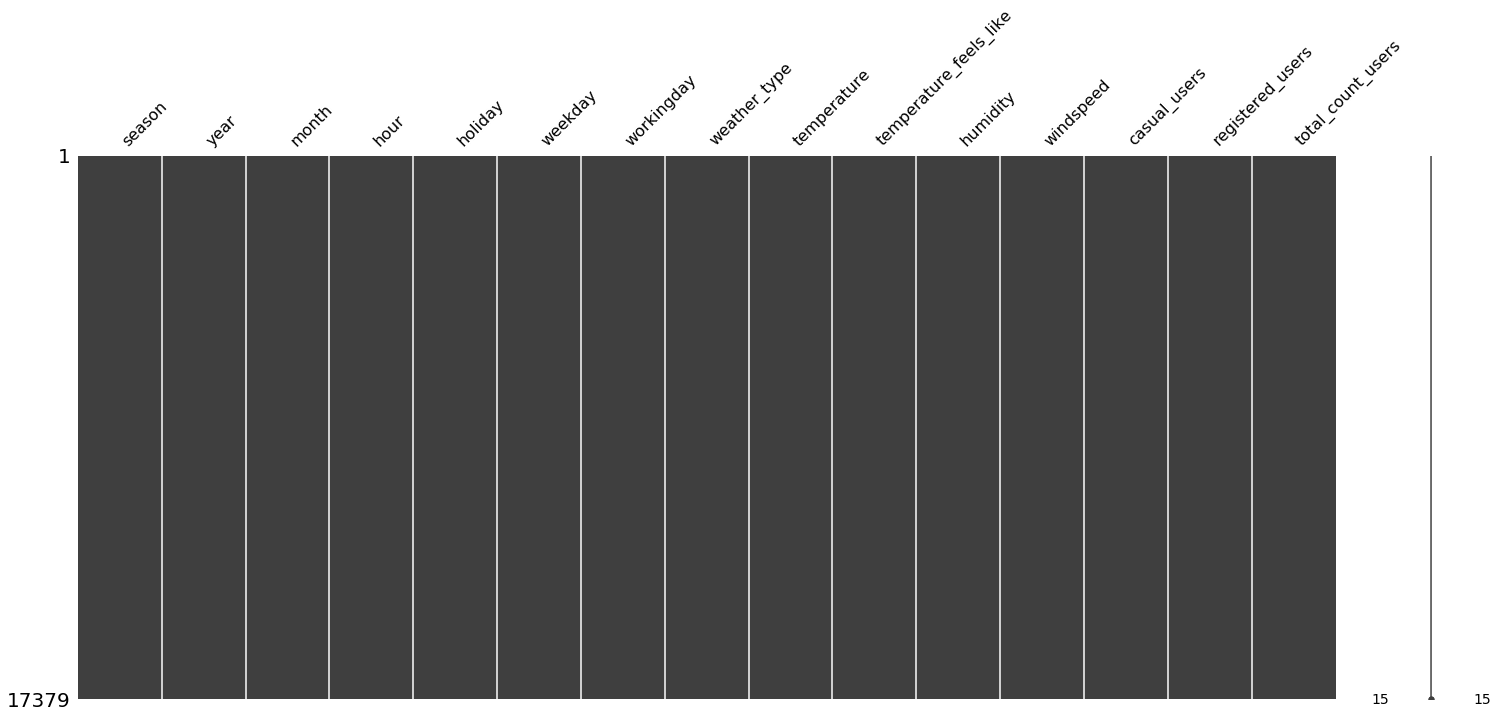

In [16]:
msno.matrix(data_hour)

We can observe from the above analysis that our data has no null values

## Univariate Analysis 

### Categorical Features - Univariate Plots

In [17]:
# Starting with the standard imports
import numpy as np                                           # numerical libraries
import pandas as pd                                          # data-frames library


# Now the Graphical libraries imports and settings
import matplotlib.pyplot as plt                              # for plotting
import seaborn as sns                                        # nicer looking plots
#%matplotlib inline

plt.rcParams[ 'figure.figsize' ] = [30,15]
plt.rcParams[ 'legend.fontsize' ] = 20
plt.rcParams[ 'axes.labelsize' ] = 20
plt.style.use ('ggplot')  # emulate ggplot style

class CategoricalFeatureSummarizer :
    EPSILON = 1e-8
    '''
    Analyze a categorical feature, and generate the usual summary from it.
    '''
    def __init__(self, data, feature, name):
        self.data            = data
        self.feature         = feature
        self.name            = name

    #----------------------------------------------------------------
    def plot_frequency(self, log=False, width=30, height=20):
        '''
        Make a frequency plot of the feature
        '''
        ax = sns.countplot(x     = self.feature, 
                           data  = self.data,
                           order = self.data[self.feature].value_counts().index);
        plt.rcParams[ 'figure.figsize' ] = width,height
            
        ax.set_title(r' {} Frequency Distribution'.format(self.name));
        ax.set_xlabel(r' {}'.format(self.name));
        ax.set_ylabel('Frequency');
        plt.xticks(rotation=90);
        
        if log:
            ax.set_yscale('log')
            ax.set_title(r' {} $Logarithmic$ Frequency Distribution'
                         .format(self.name))
        plt.show()
    #----------------------------------------------------------------    
    def print_topN (self, topN=20, log=False):
        '''
        Print the top-N most frequent values for this feature
        '''
        if (log):
            tn = np.log(self.data[self.feature].value_counts())[0:topN]
        else:
            tn = self.data[self.feature].value_counts()[0:topN]
            
        print(tn)


#---------------------------------------------------------------------------


def displayColumnTypes (data):
    columnMeta = pd.DataFrame(columns=['Feature', 'Datatype'])
    for column in data.columns: 
        columnMeta = columnMeta.append({'Feature':column, 
                                        'Datatype': data[column].dtype}, 
                                       ignore_index=True)
    return columnMeta

#### Season Summary

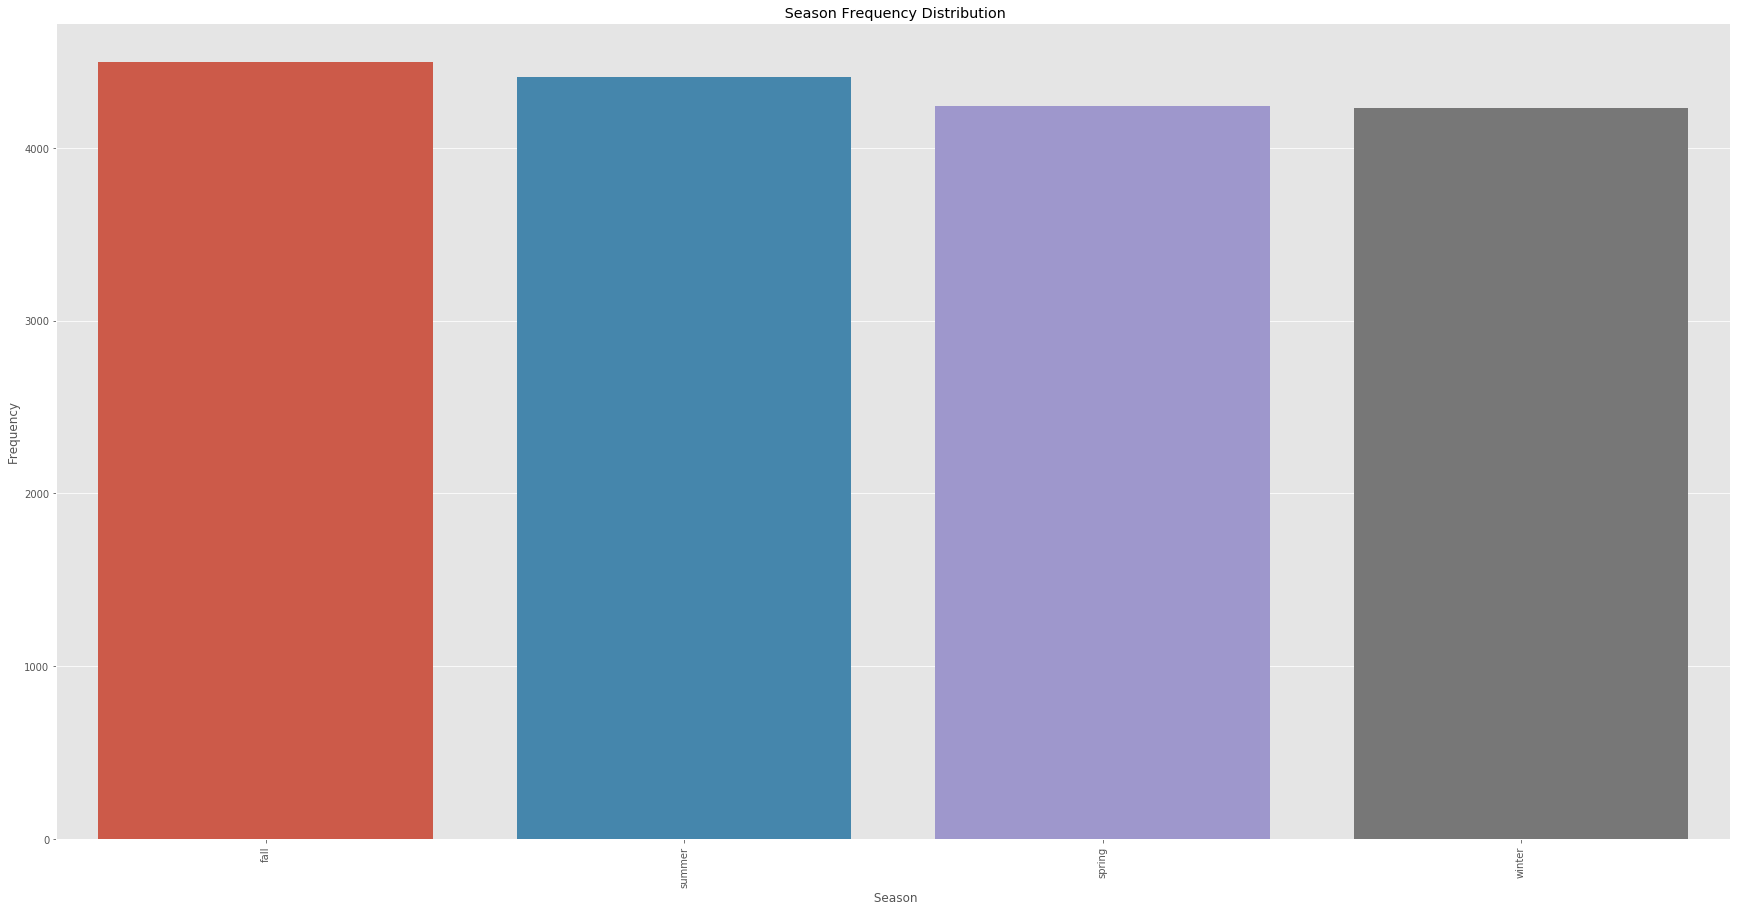

In [18]:
summarizer = CategoricalFeatureSummarizer(data_hour, "season", "Season")
summarizer.plot_frequency()

#### Year Summary

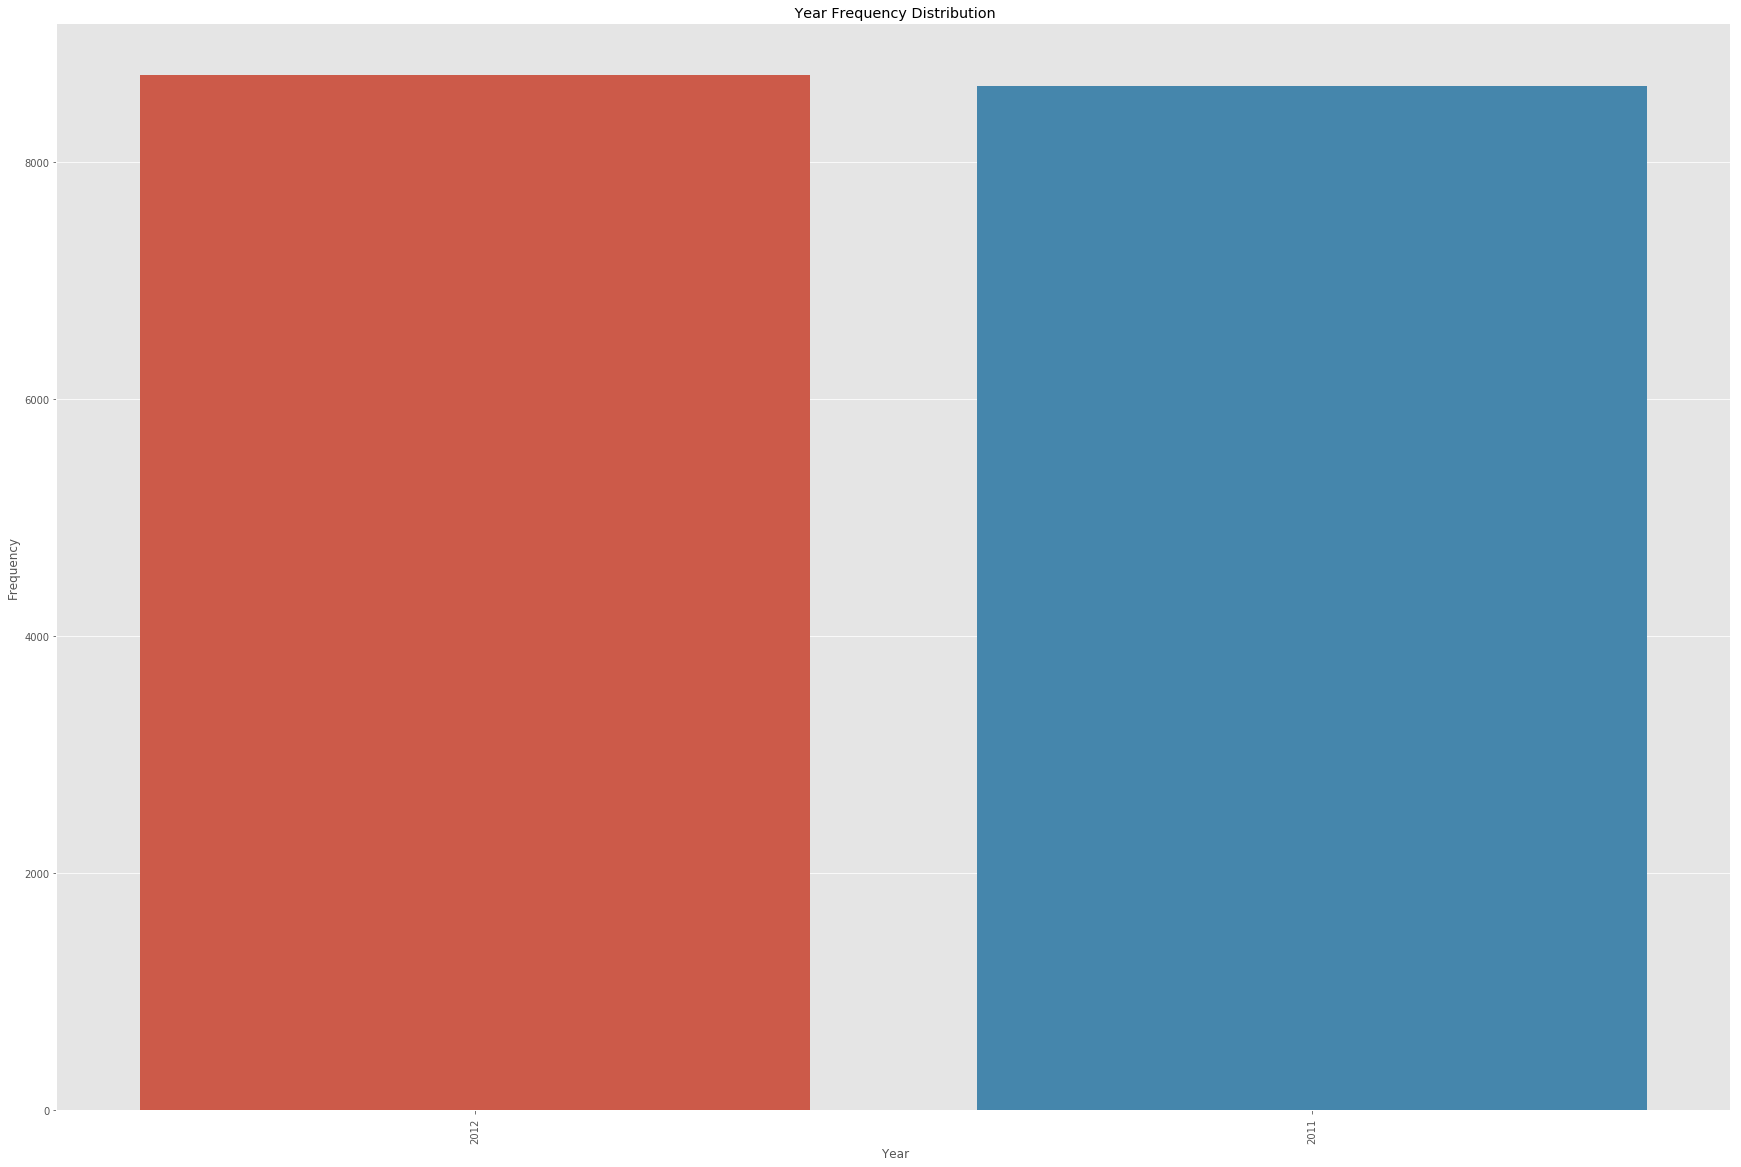

In [19]:
summarizer = CategoricalFeatureSummarizer(data_hour, "year", "Year")
summarizer.plot_frequency()

#### Month Summary 

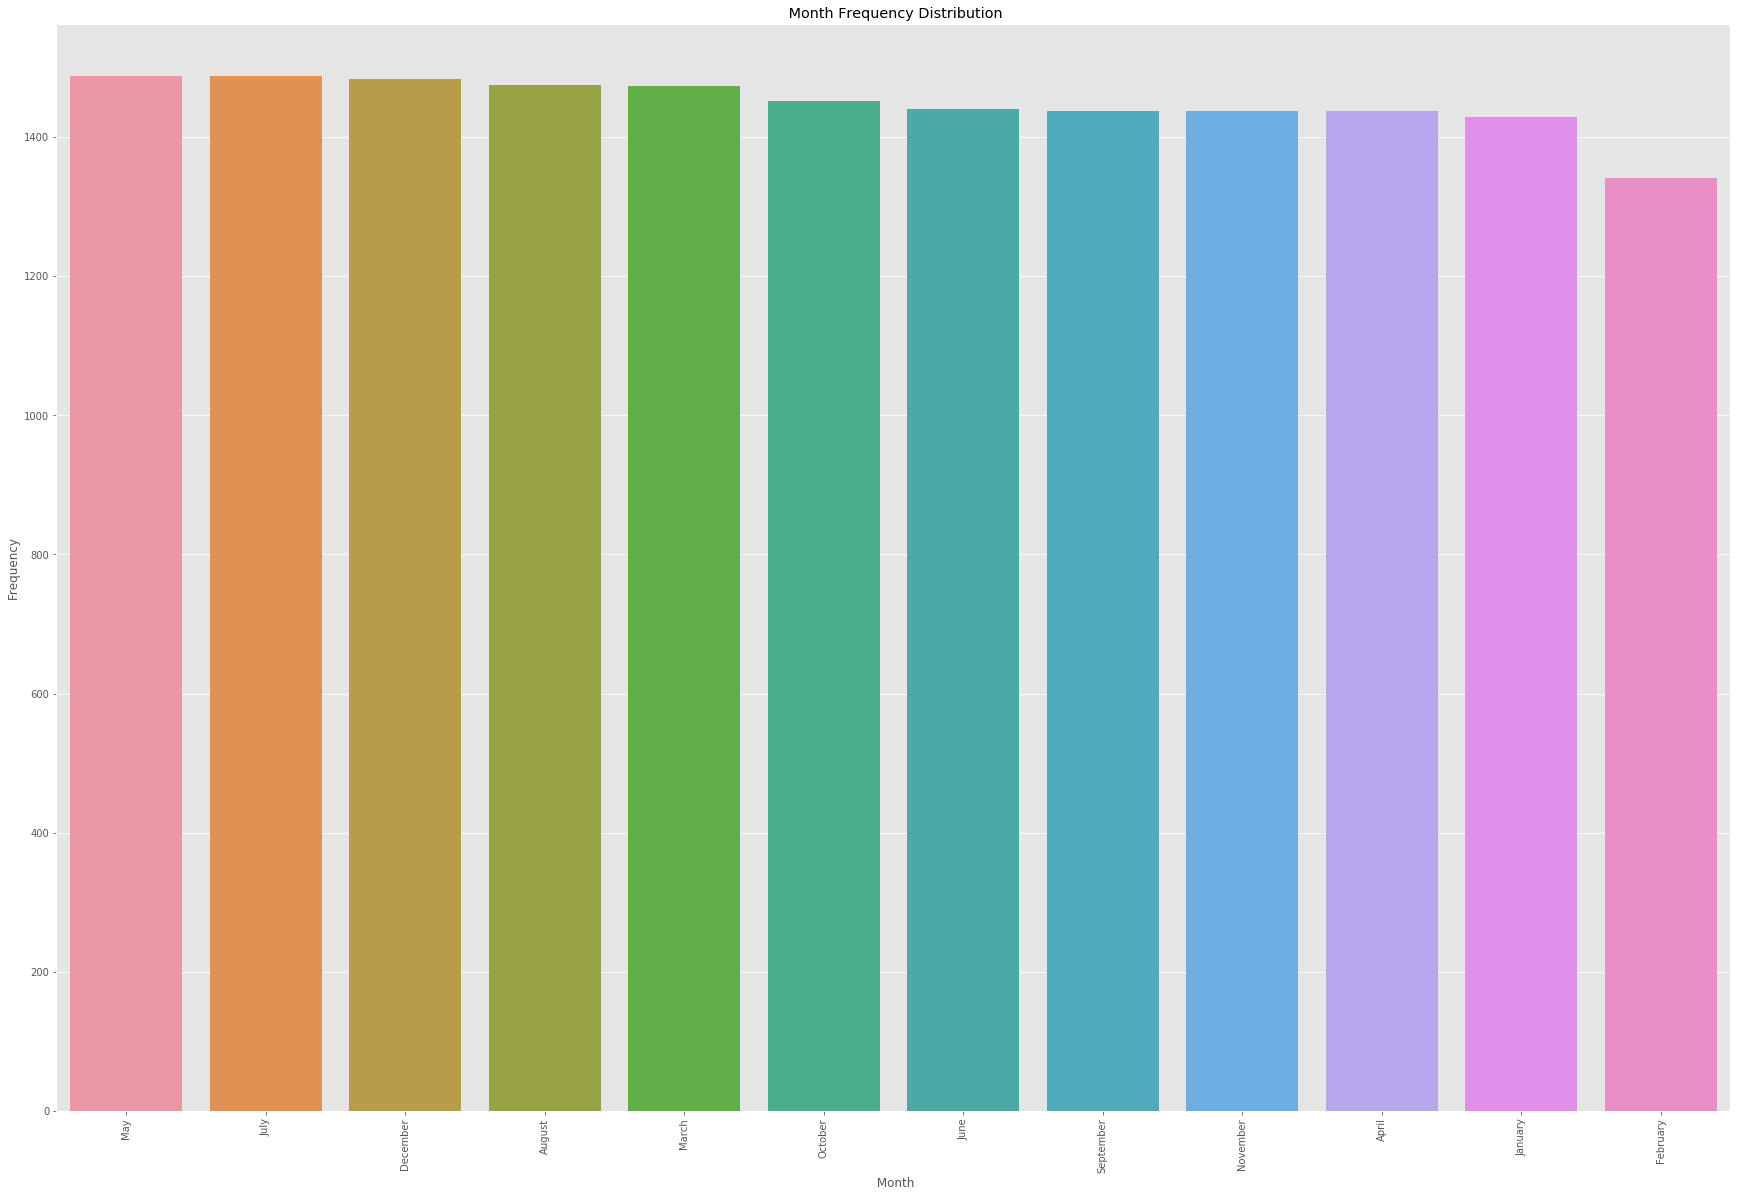

In [20]:
summarizer = CategoricalFeatureSummarizer(data_hour, "month", "Month")
summarizer.plot_frequency()

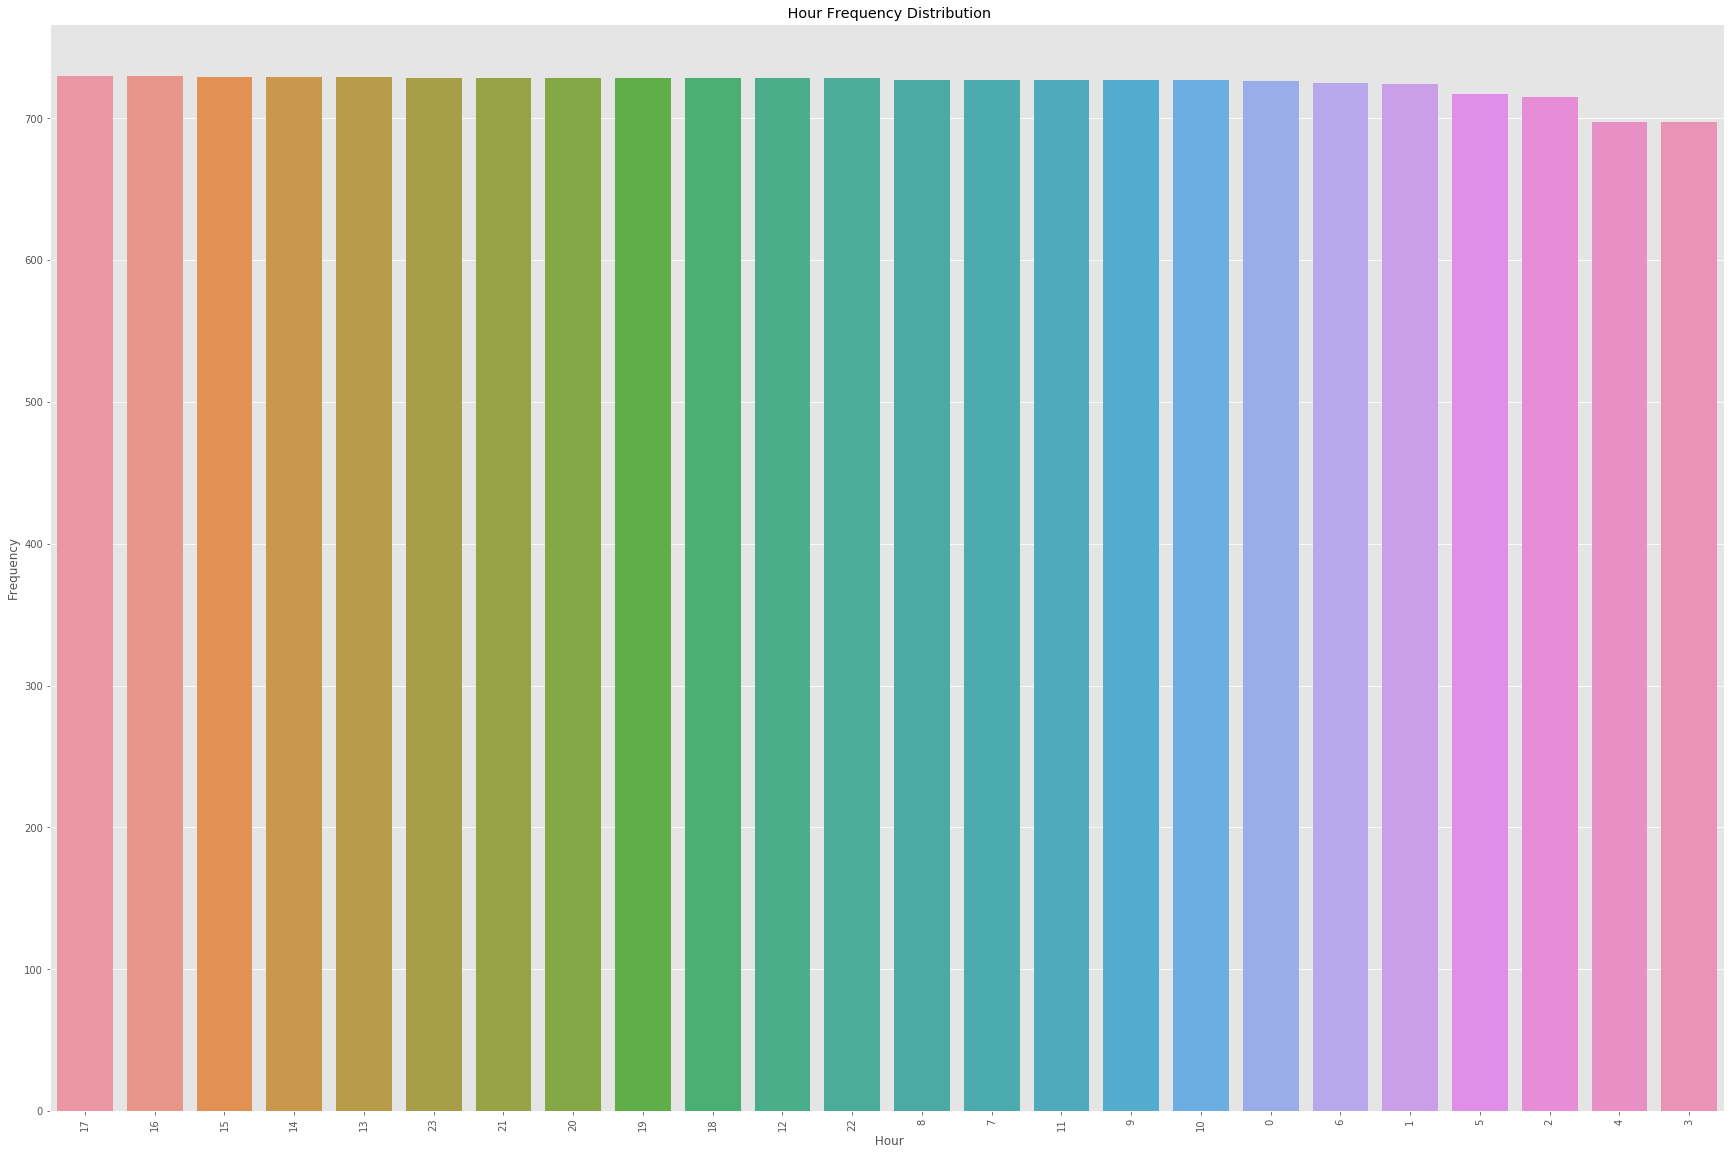

In [22]:
summarizer = CategoricalFeatureSummarizer(data_hour, "hour", "Hour")
summarizer.plot_frequency()

#### Holiday Summary 

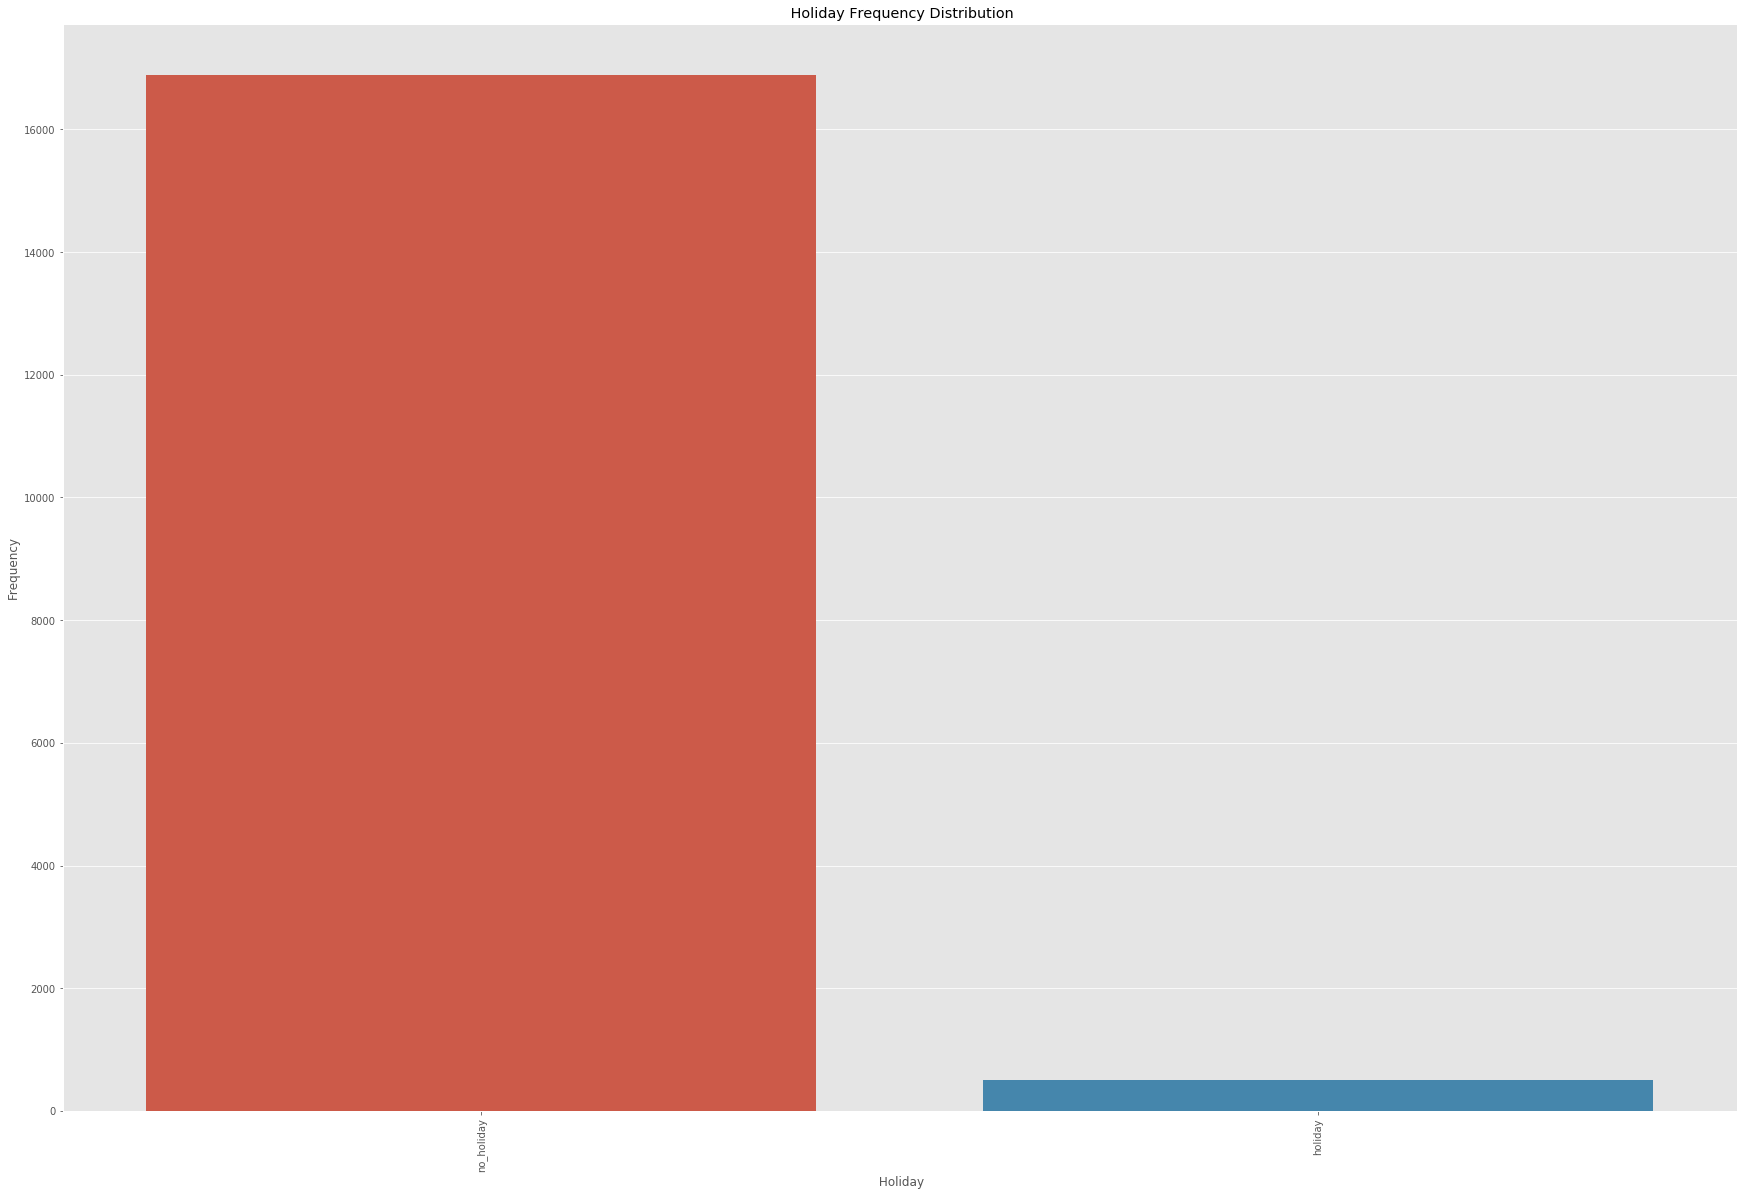

In [23]:
summarizer = CategoricalFeatureSummarizer(data_hour, "holiday", "Holiday")
summarizer.plot_frequency()

#### Week-day Summary

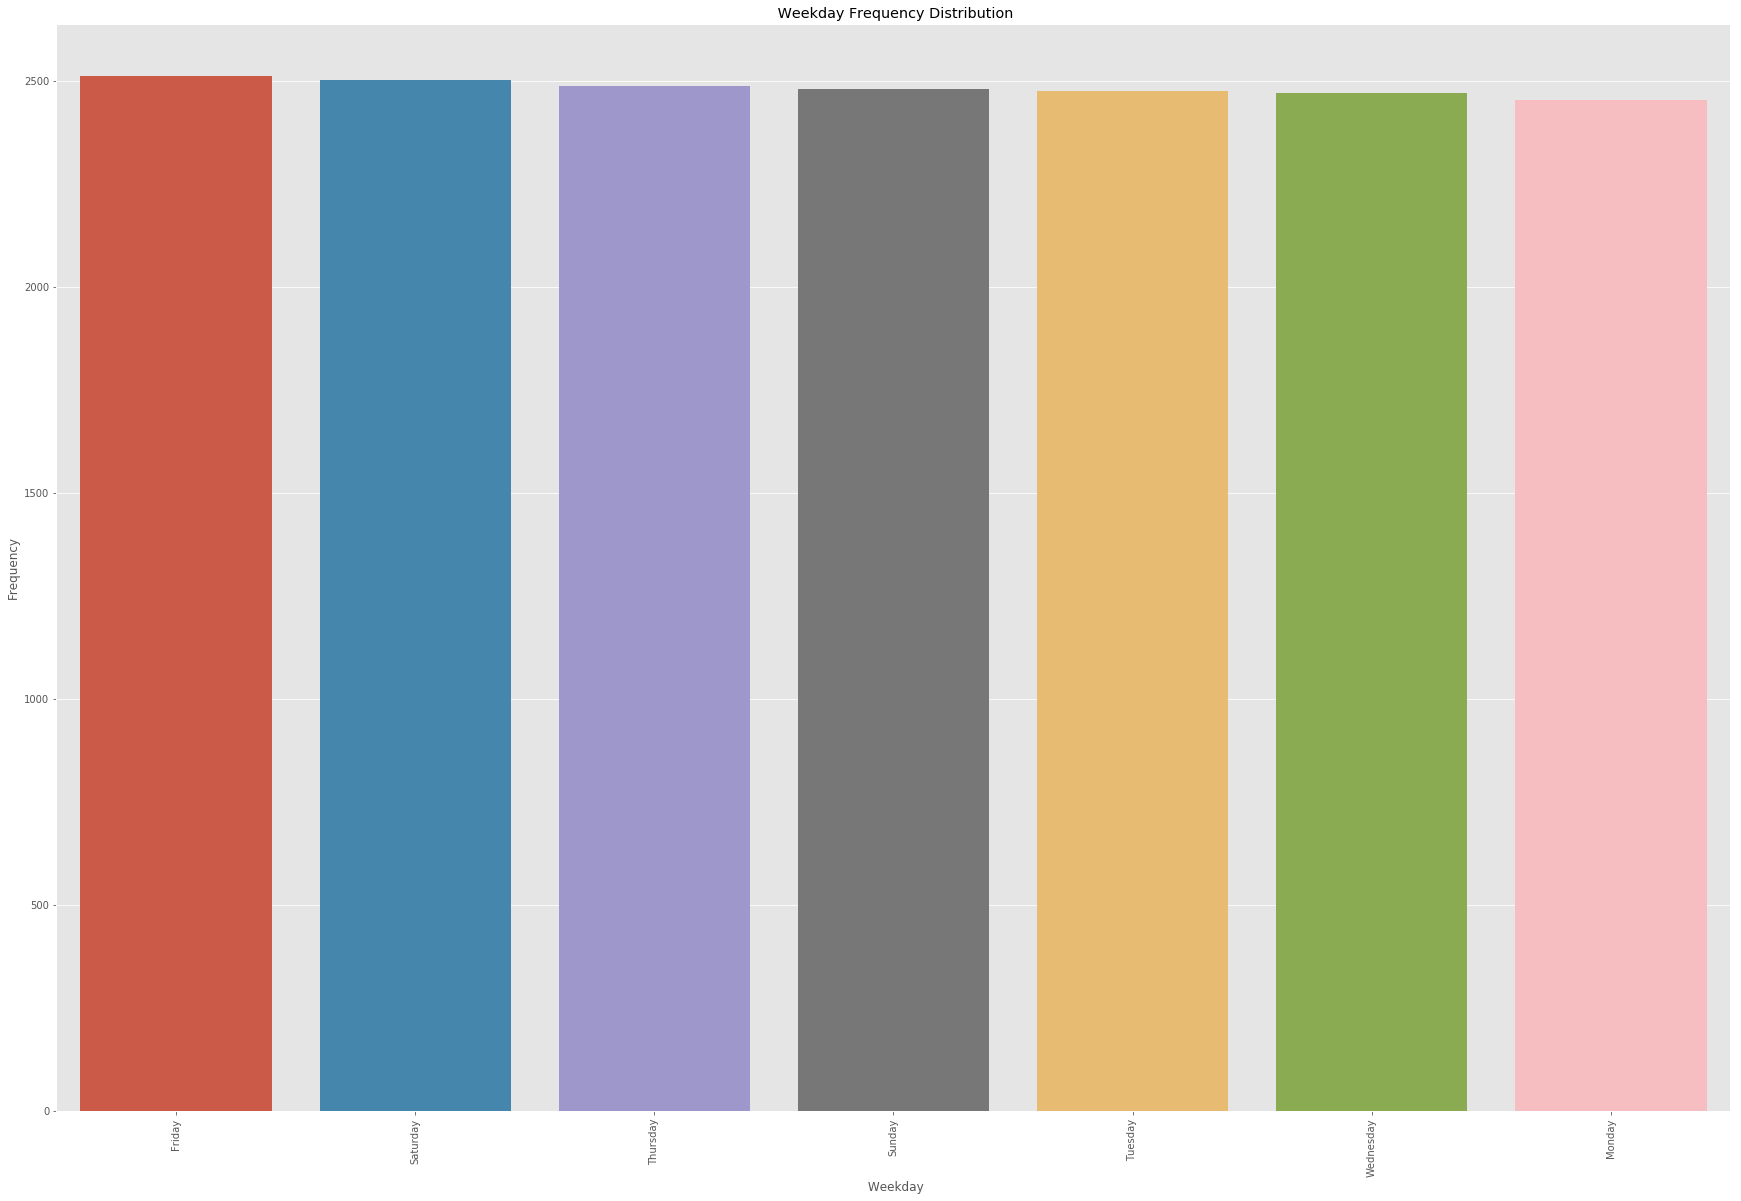

In [24]:
summarizer = CategoricalFeatureSummarizer(data_hour, "weekday", "Weekday")
summarizer.plot_frequency()

#### Working Day Summary

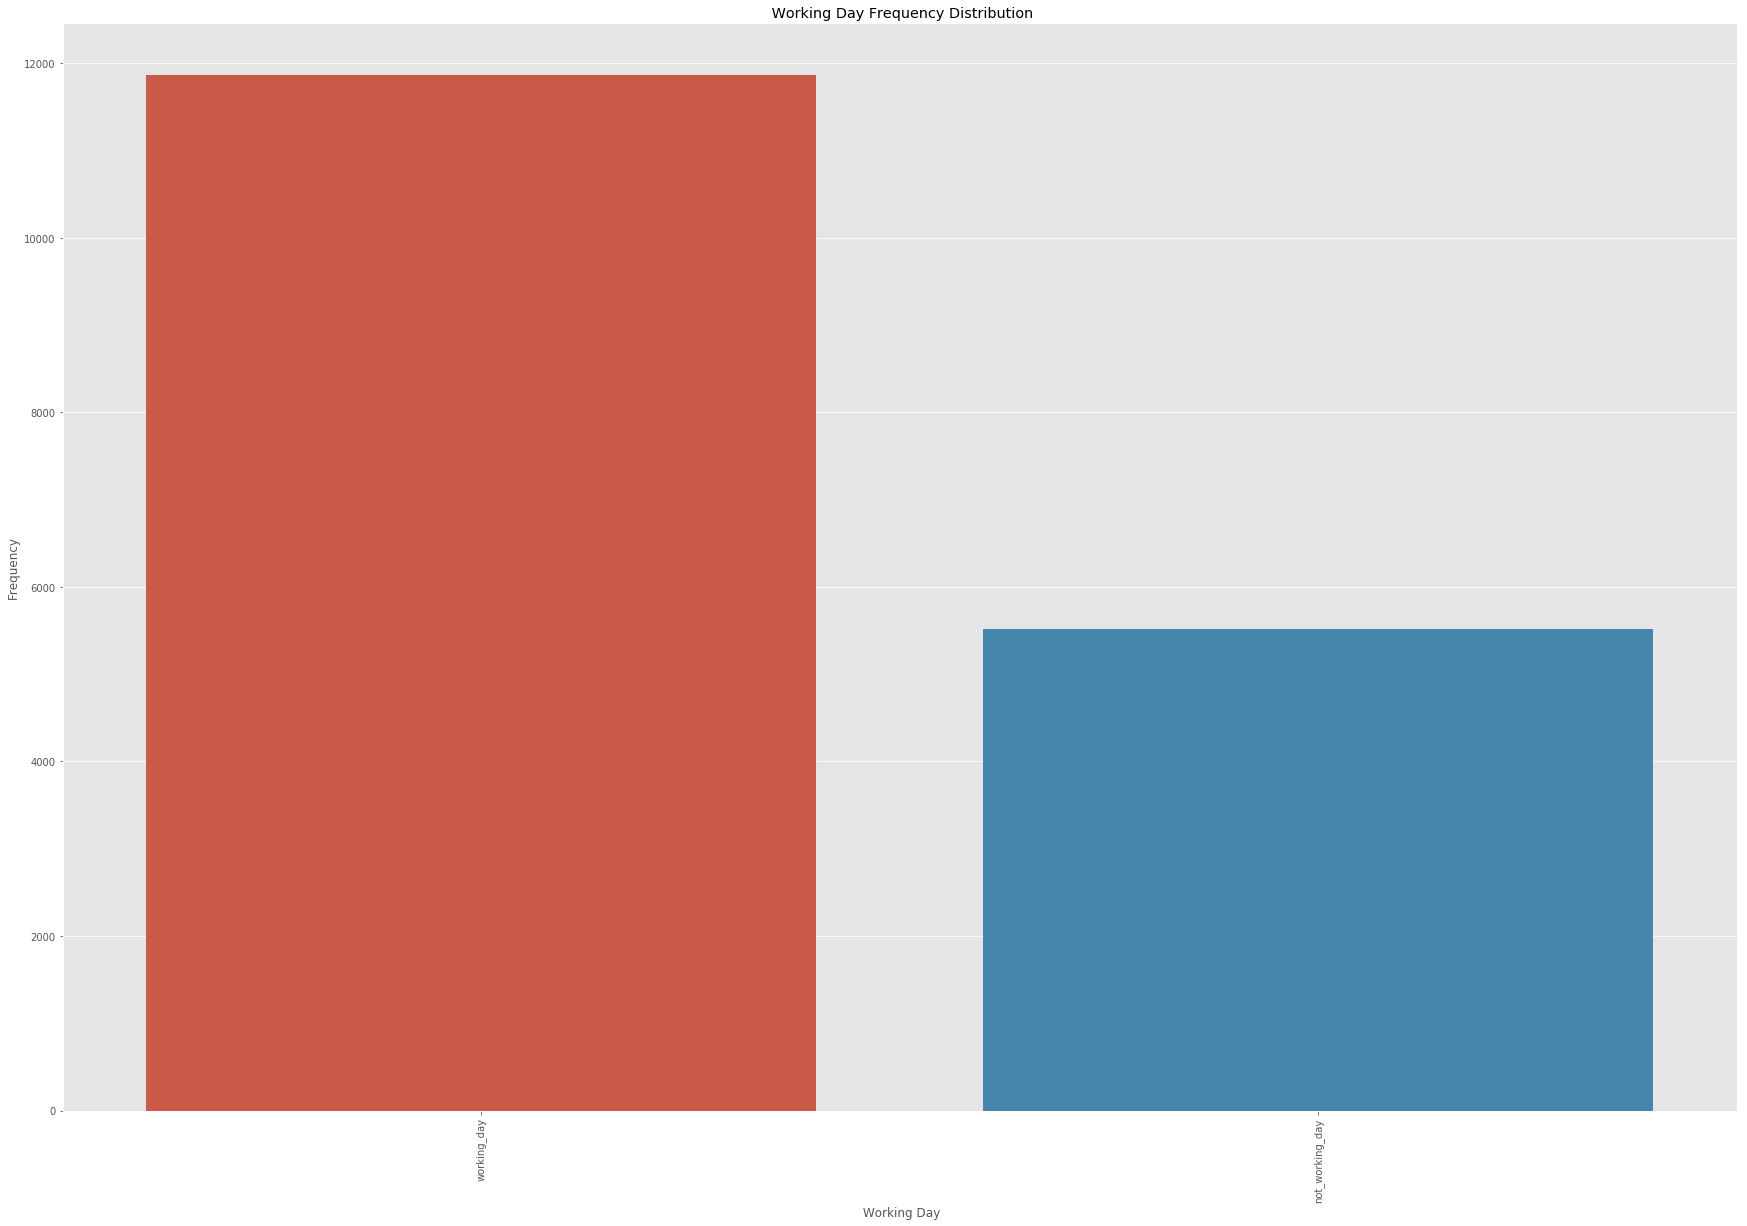

In [25]:
summarizer = CategoricalFeatureSummarizer(data_hour, "workingday", "Working Day")
summarizer.plot_frequency()

#### Weather Type Summary

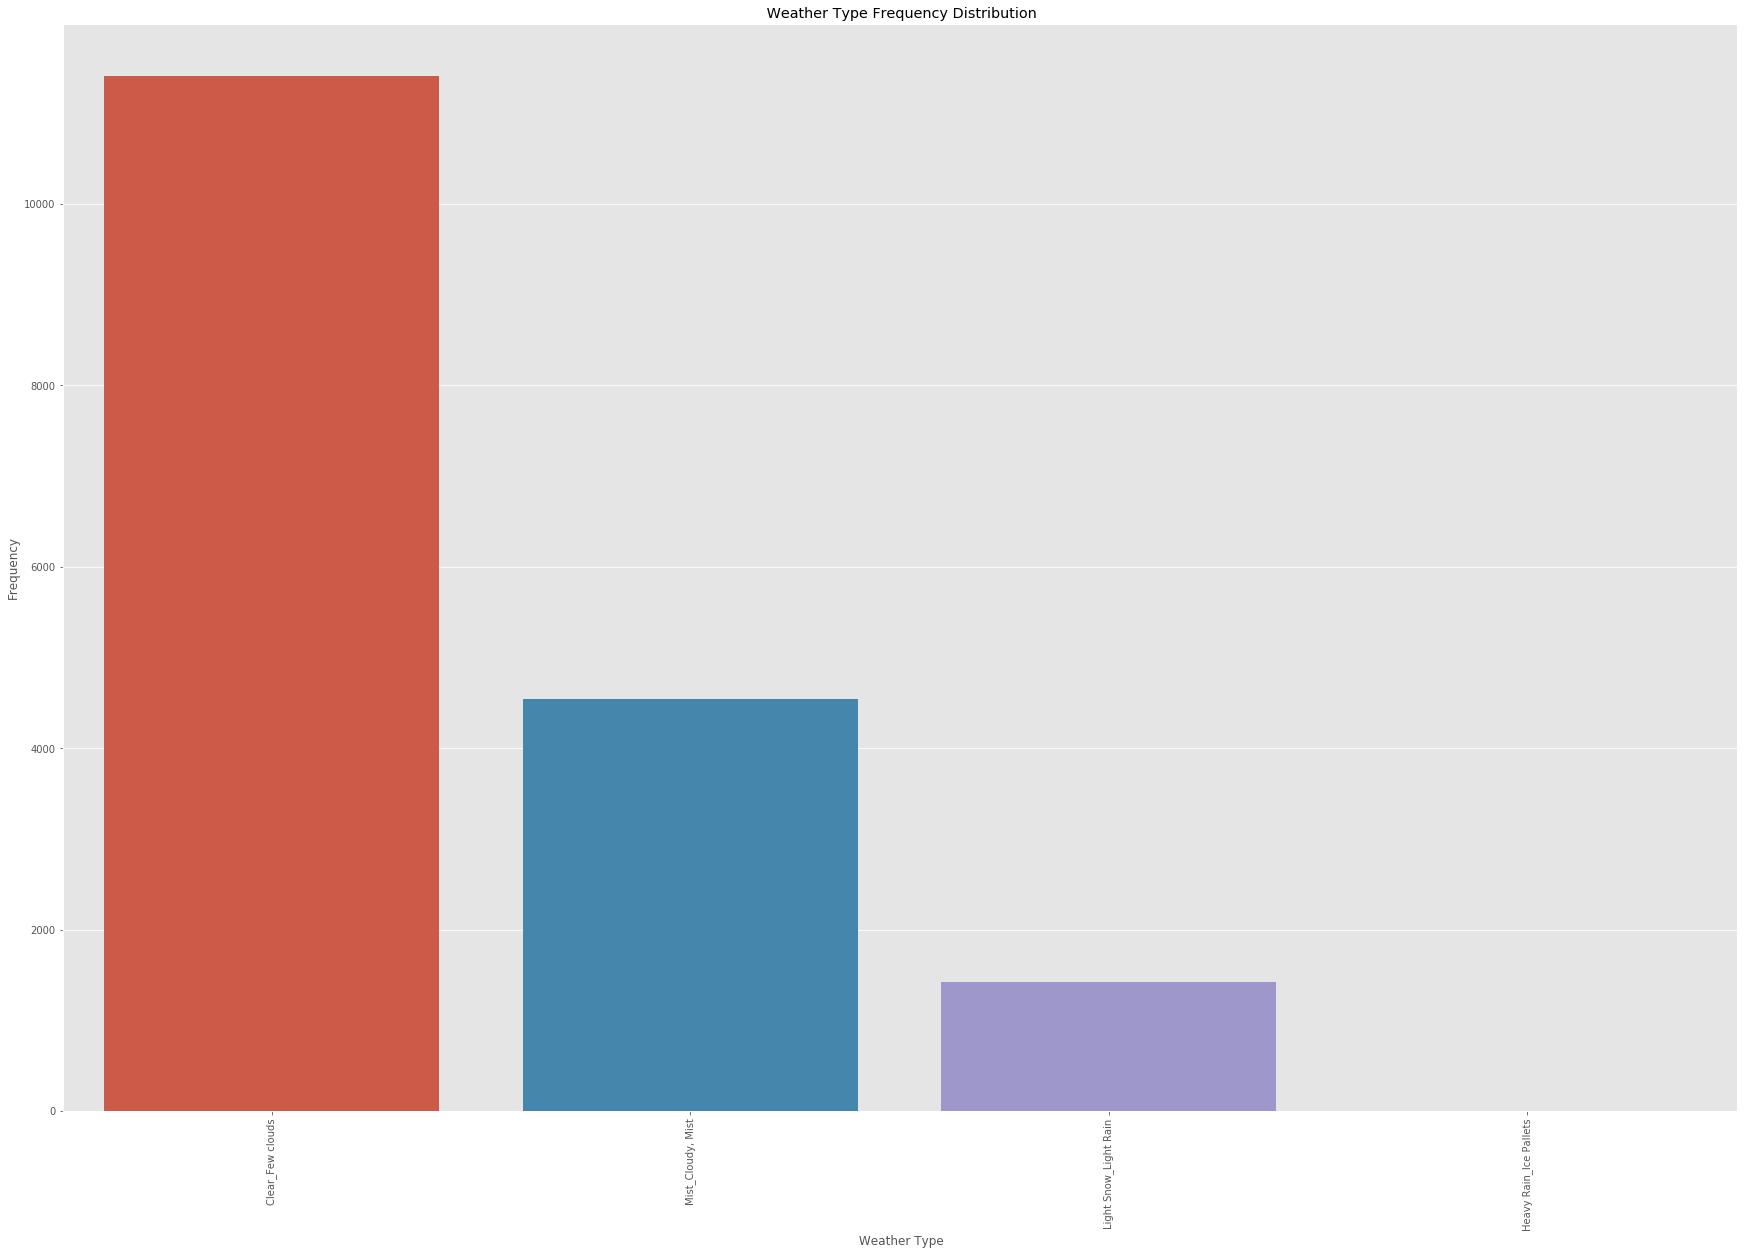

In [26]:
summarizer = CategoricalFeatureSummarizer(data_hour, "weather_type", "Weather Type")
summarizer.plot_frequency()

### The $\mathbb{R}$-Valued Fields
Now, we make the histogram for each of the real-valued fields.

#### Distribution of Temperature

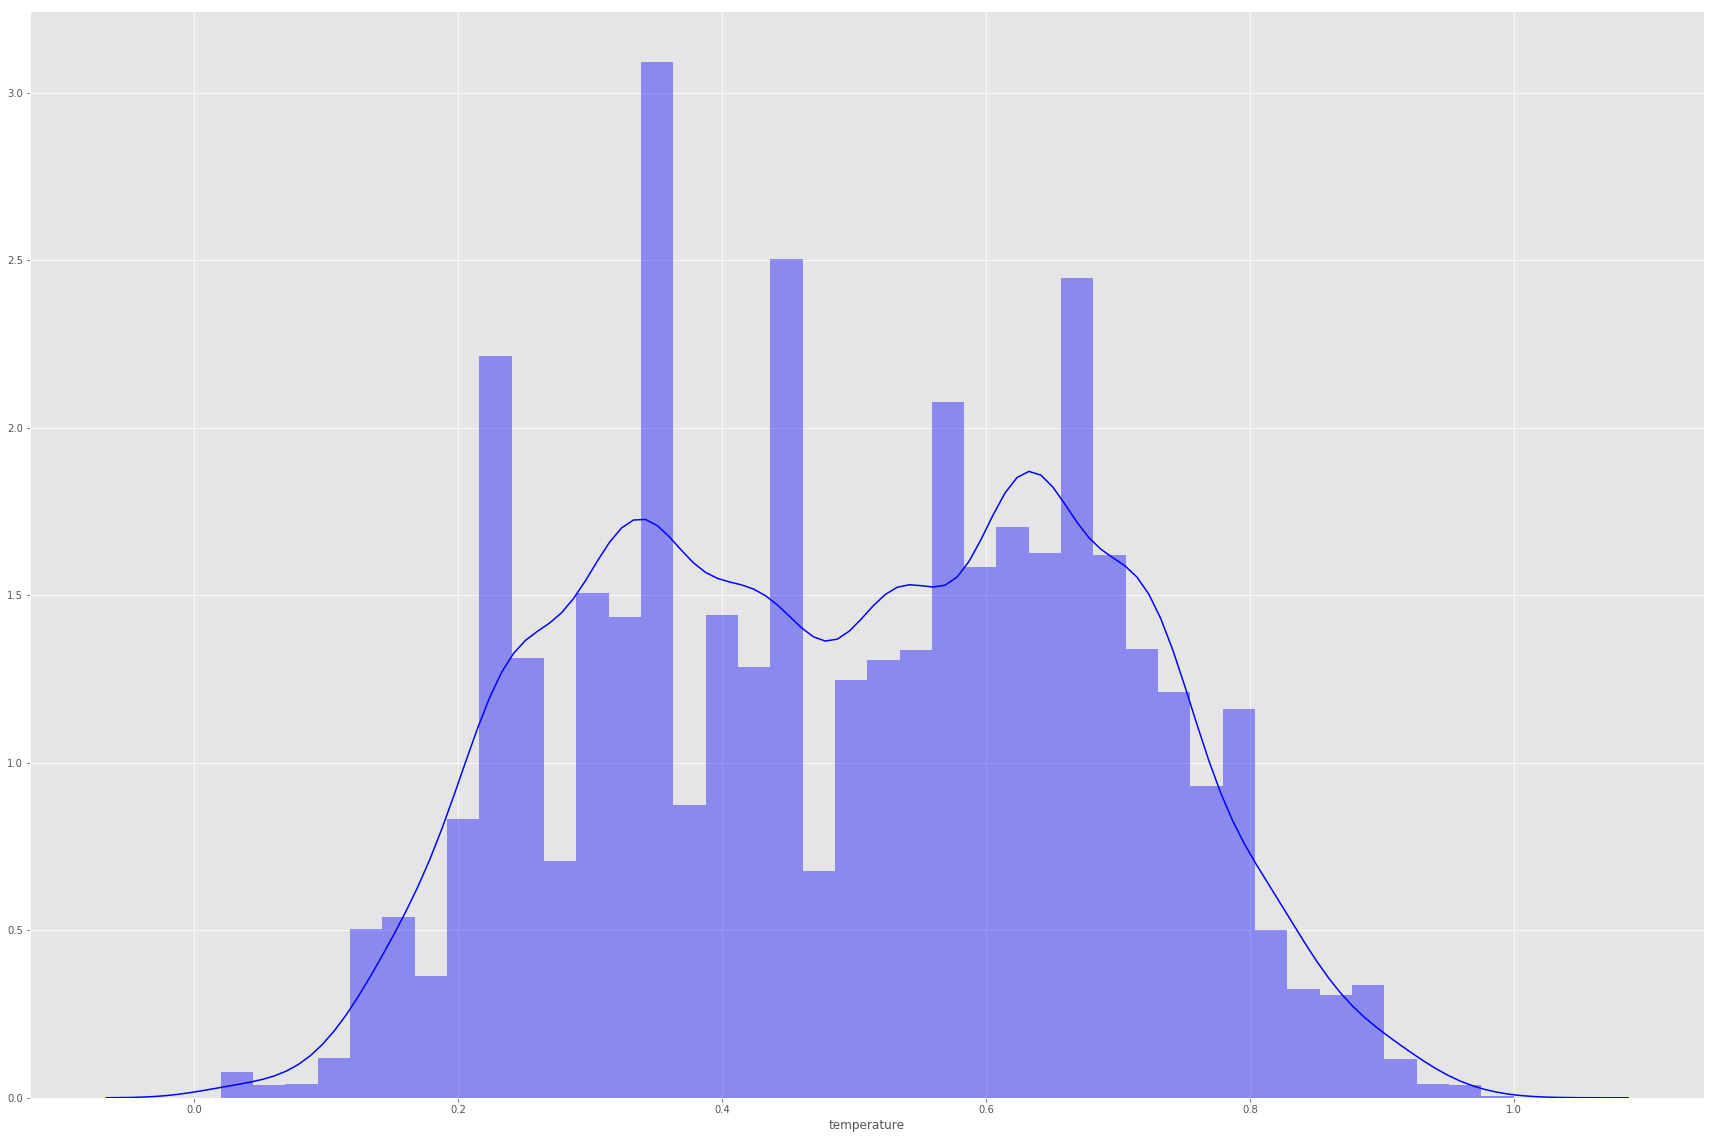

In [27]:
sns.distplot(data_hour["temperature"], color="blue")

#### Distribution of Feels-Like Temperature

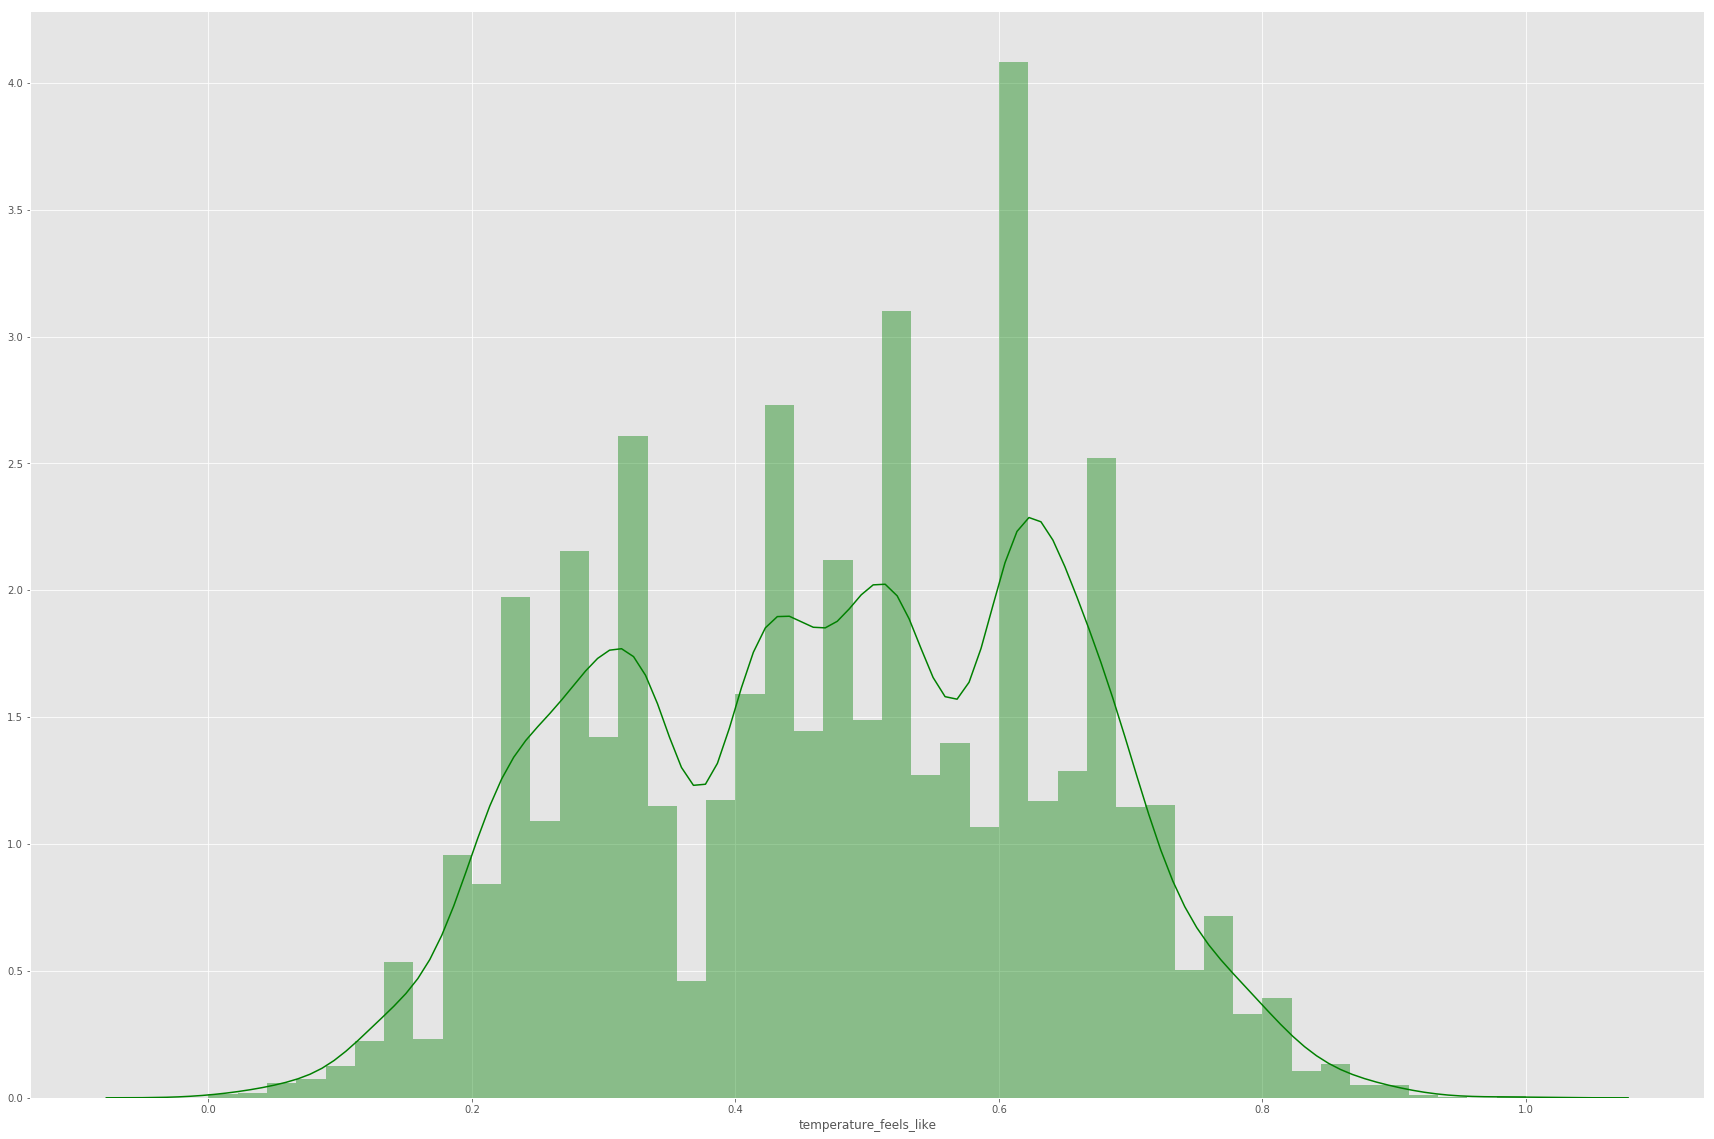

In [28]:
sns.distplot(data_hour["temperature_feels_like"], color="green")

#### Distribution of Humidity

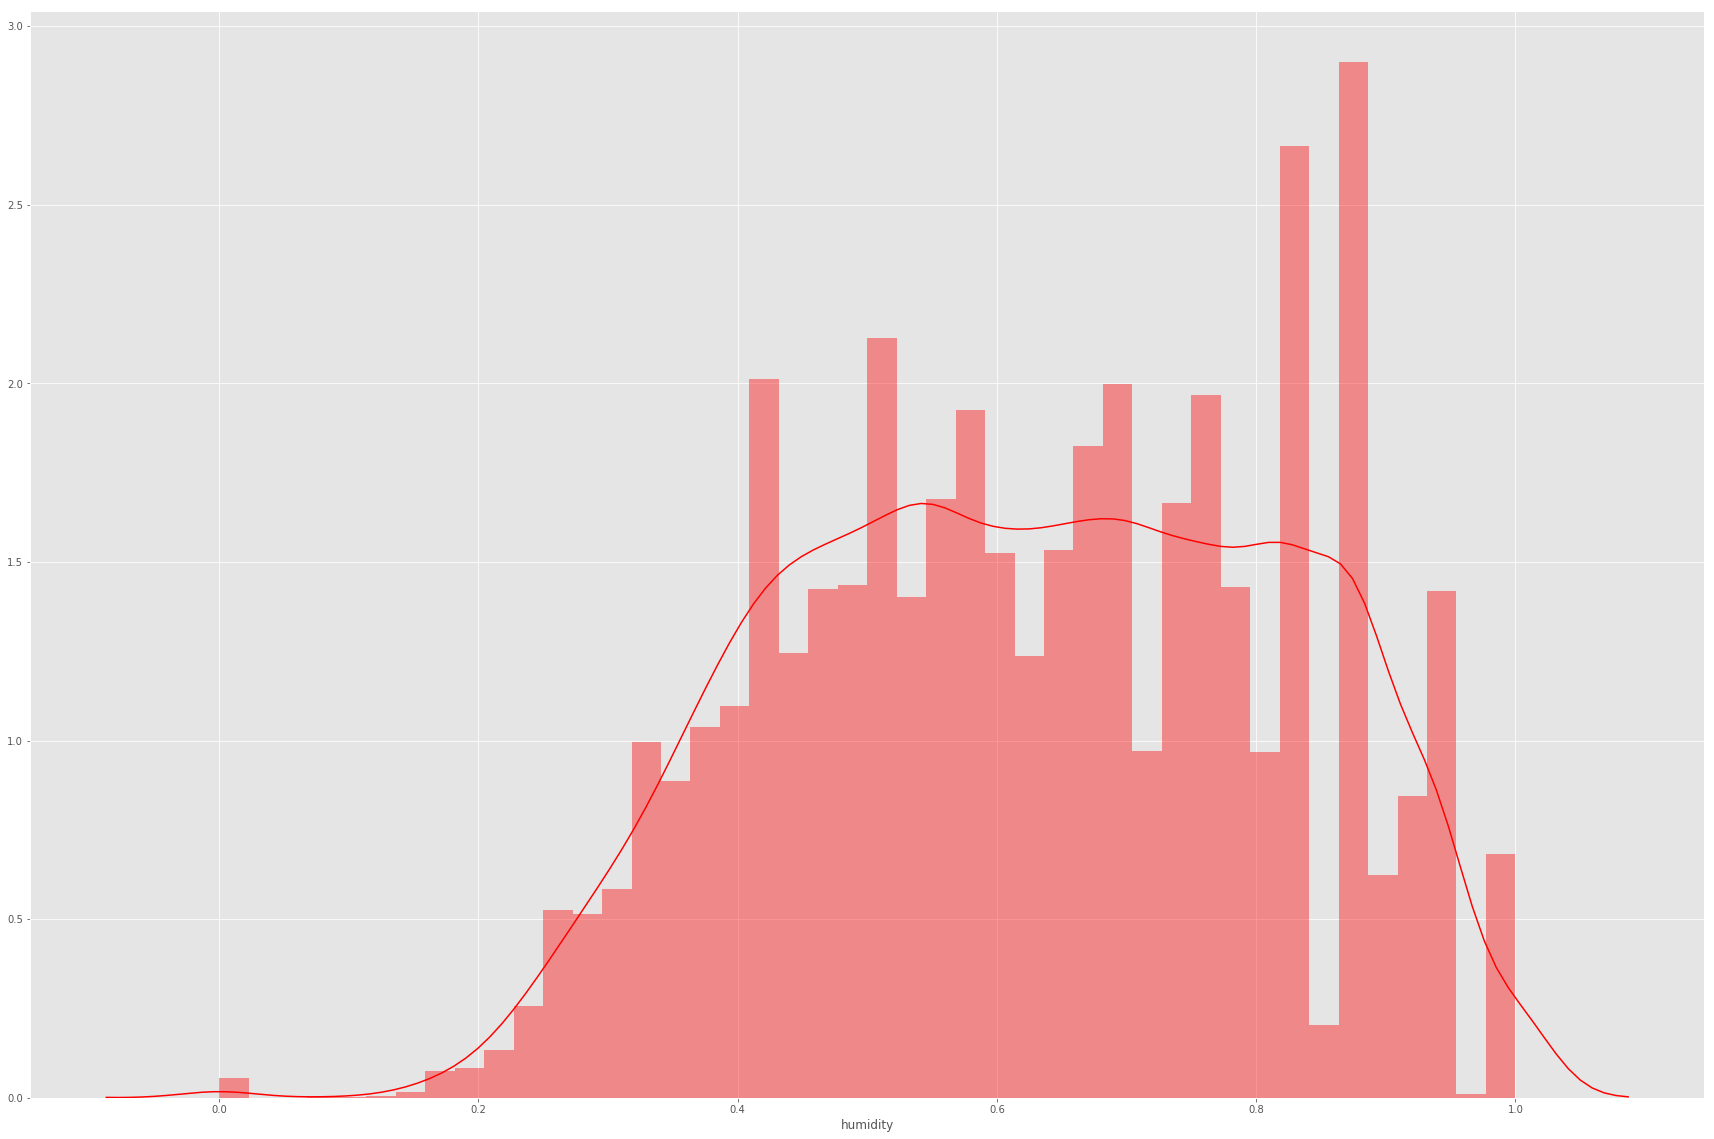

In [29]:
sns.distplot(data_hour["humidity"], color="red")

#### Distribution of Wind-speed

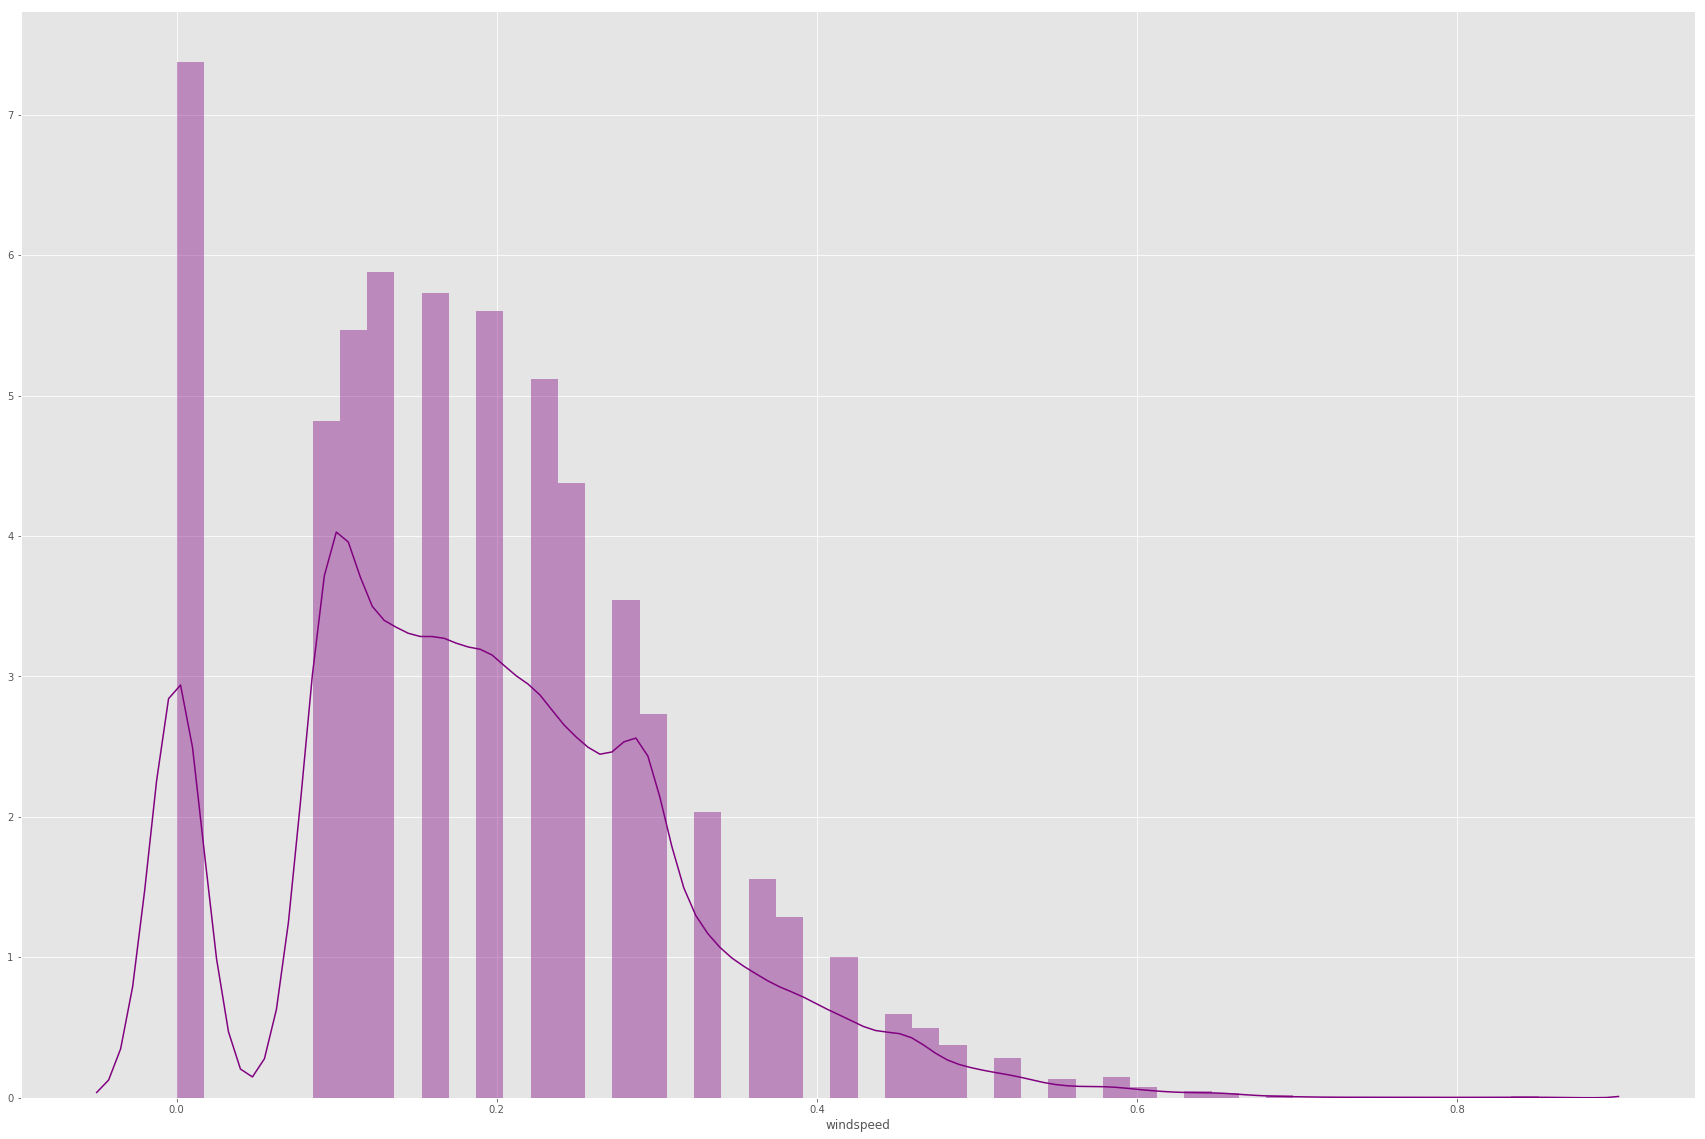

In [30]:
sns.distplot(data_hour["windspeed"], color="purple")

#### Distribution of Casual Users

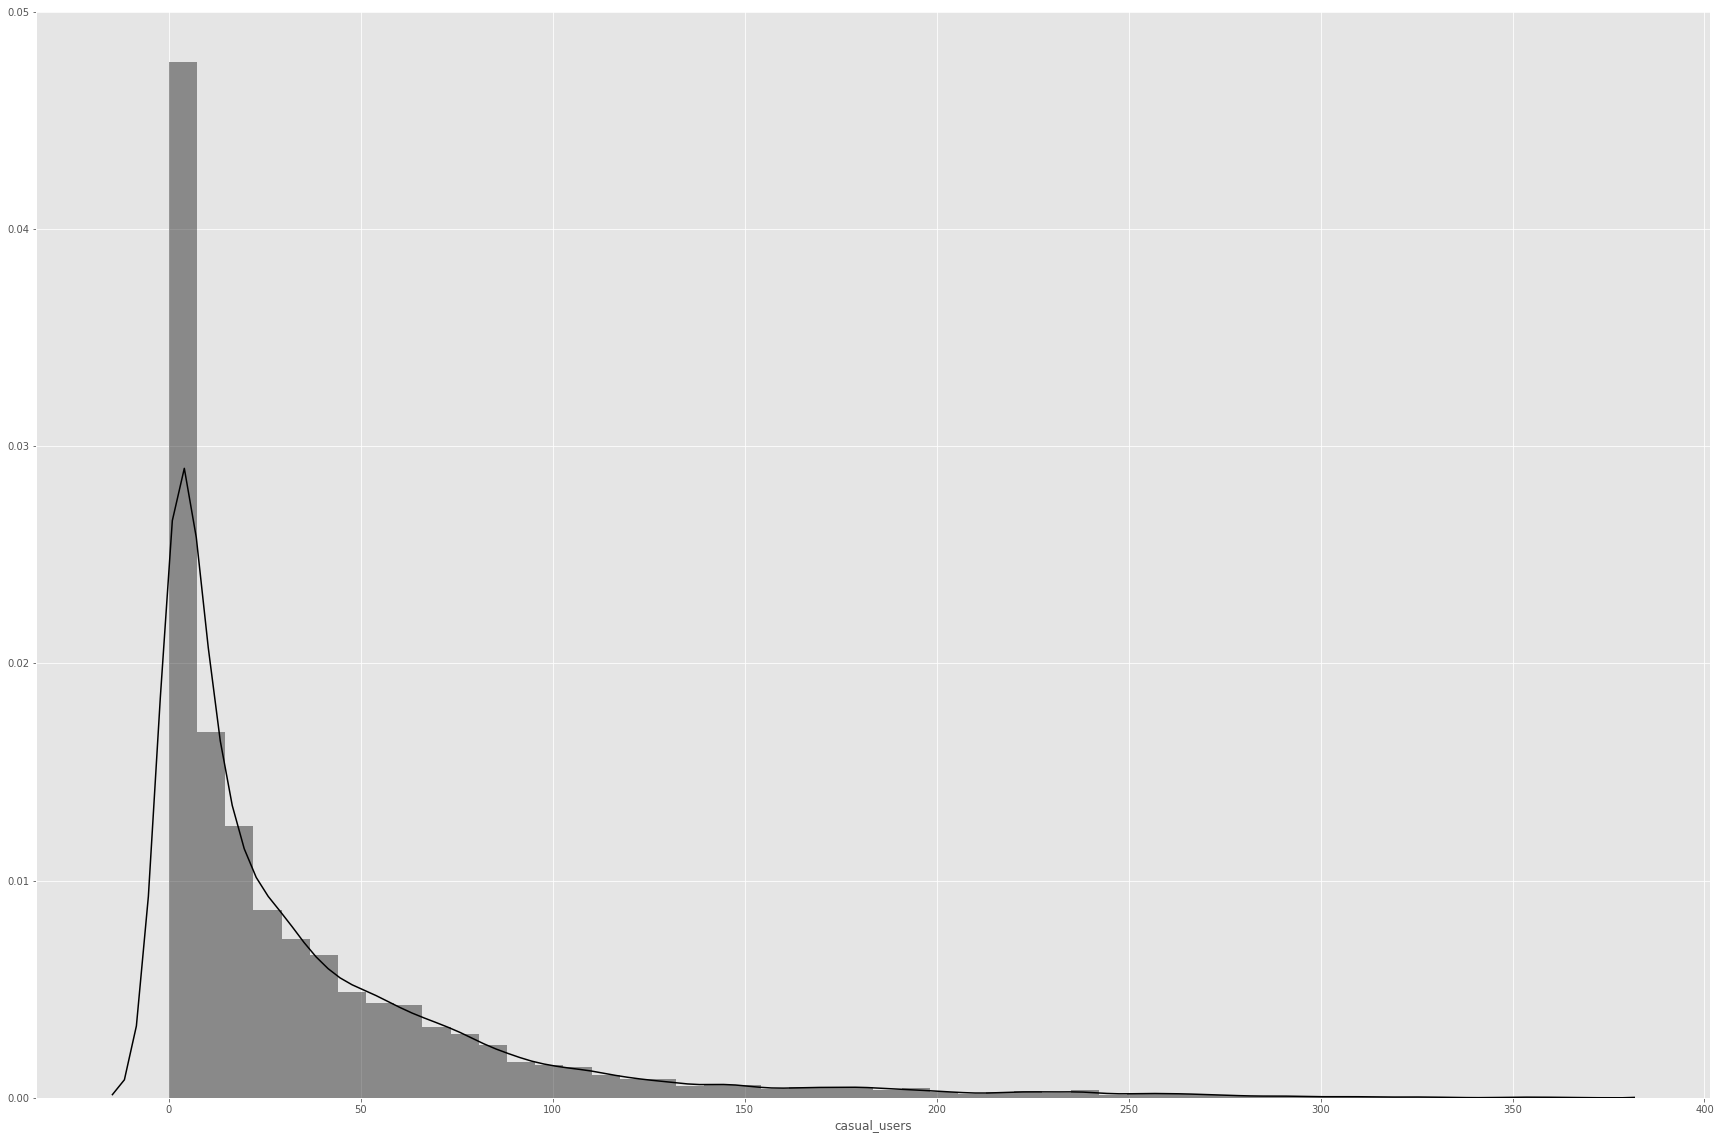

In [31]:
sns.distplot(data_hour["casual_users"], color="black")

#### Distribution of Registered Users

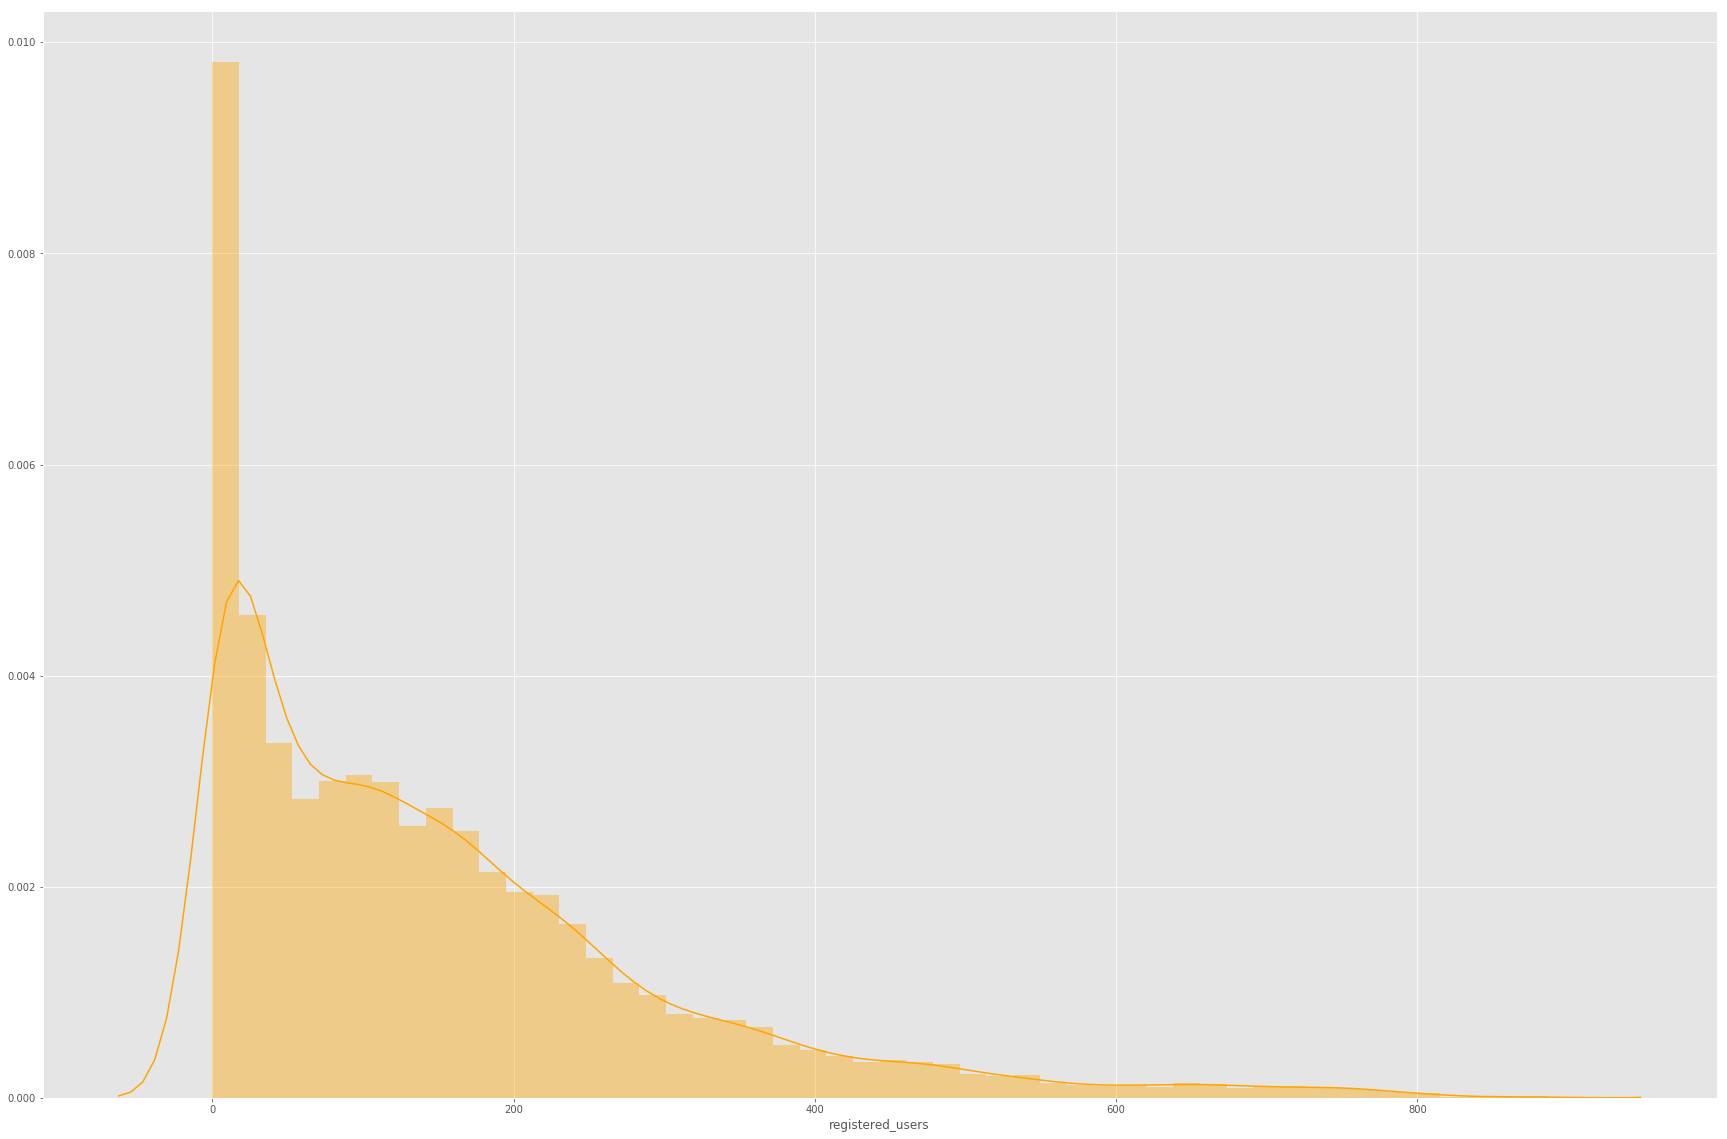

In [32]:
sns.distplot(data_hour["registered_users"], color="orange")

#### Distribution of Total Users

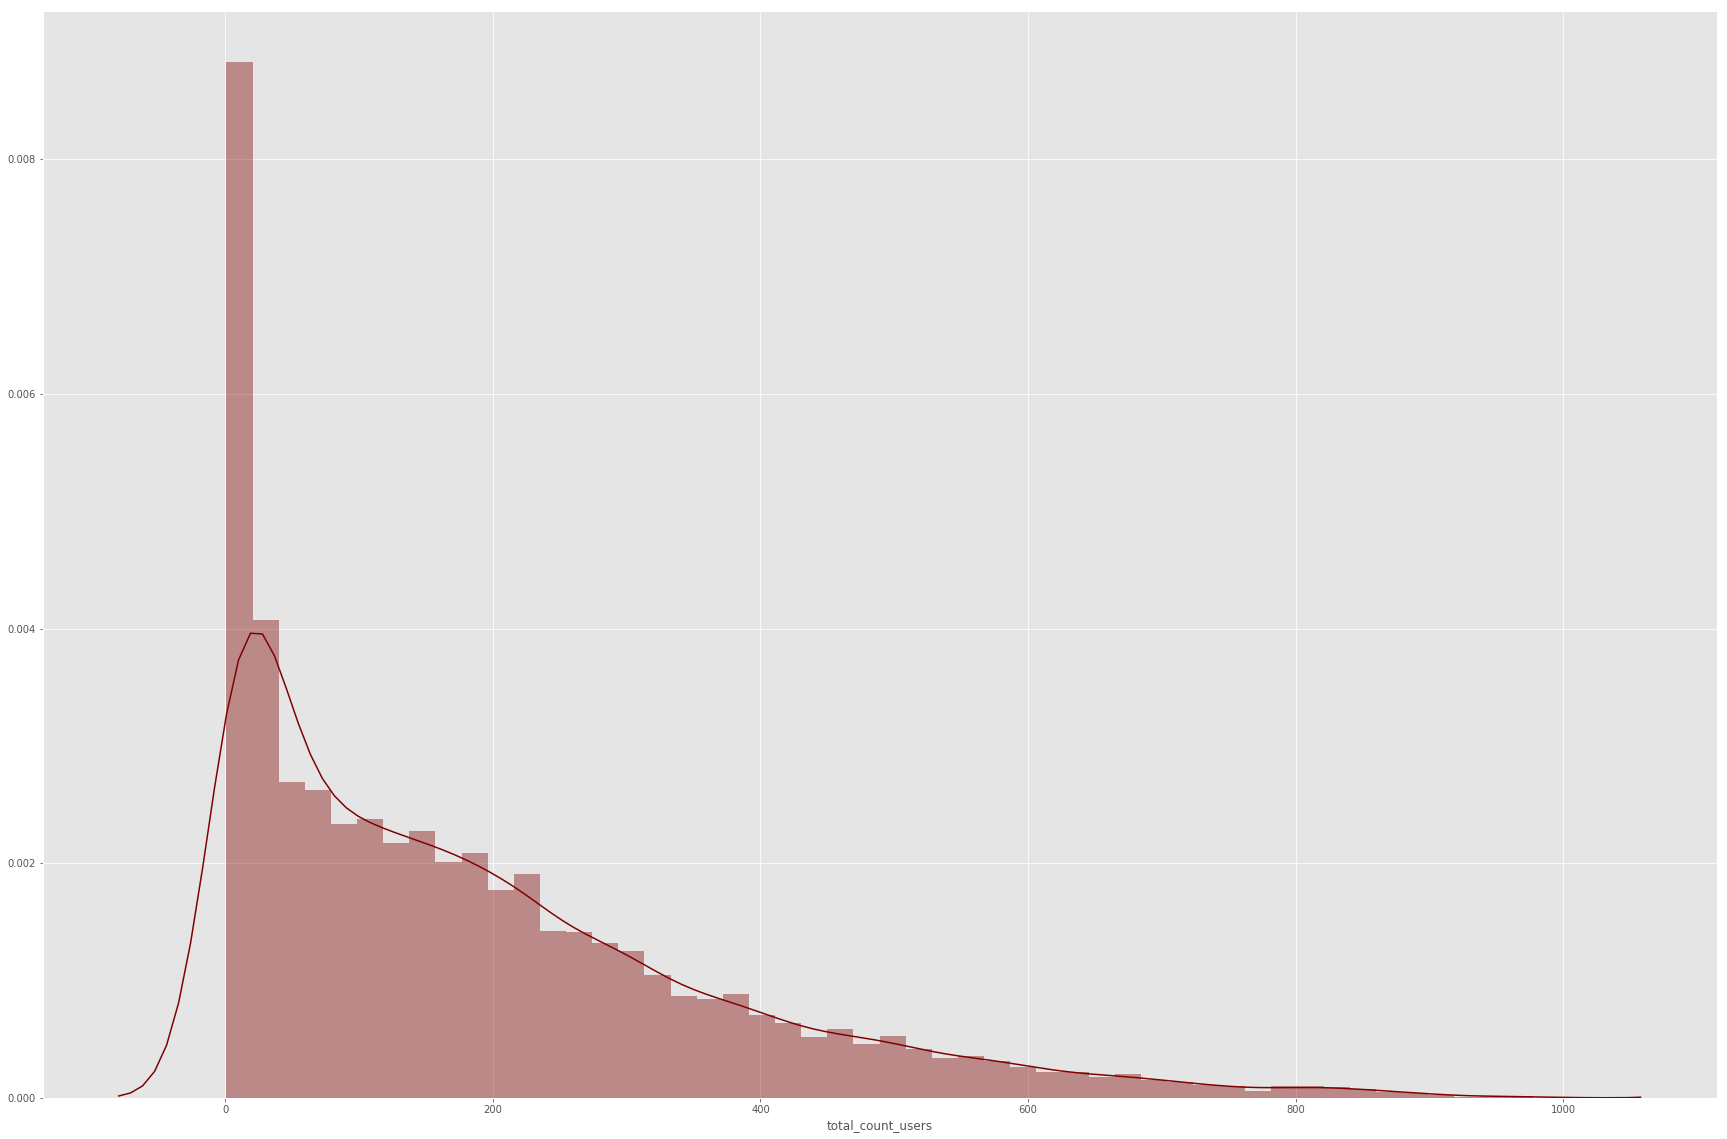

In [33]:
sns.distplot(data_hour["total_count_users"], color="maroon")

## Bivariate Analysis 

### Pair Plot

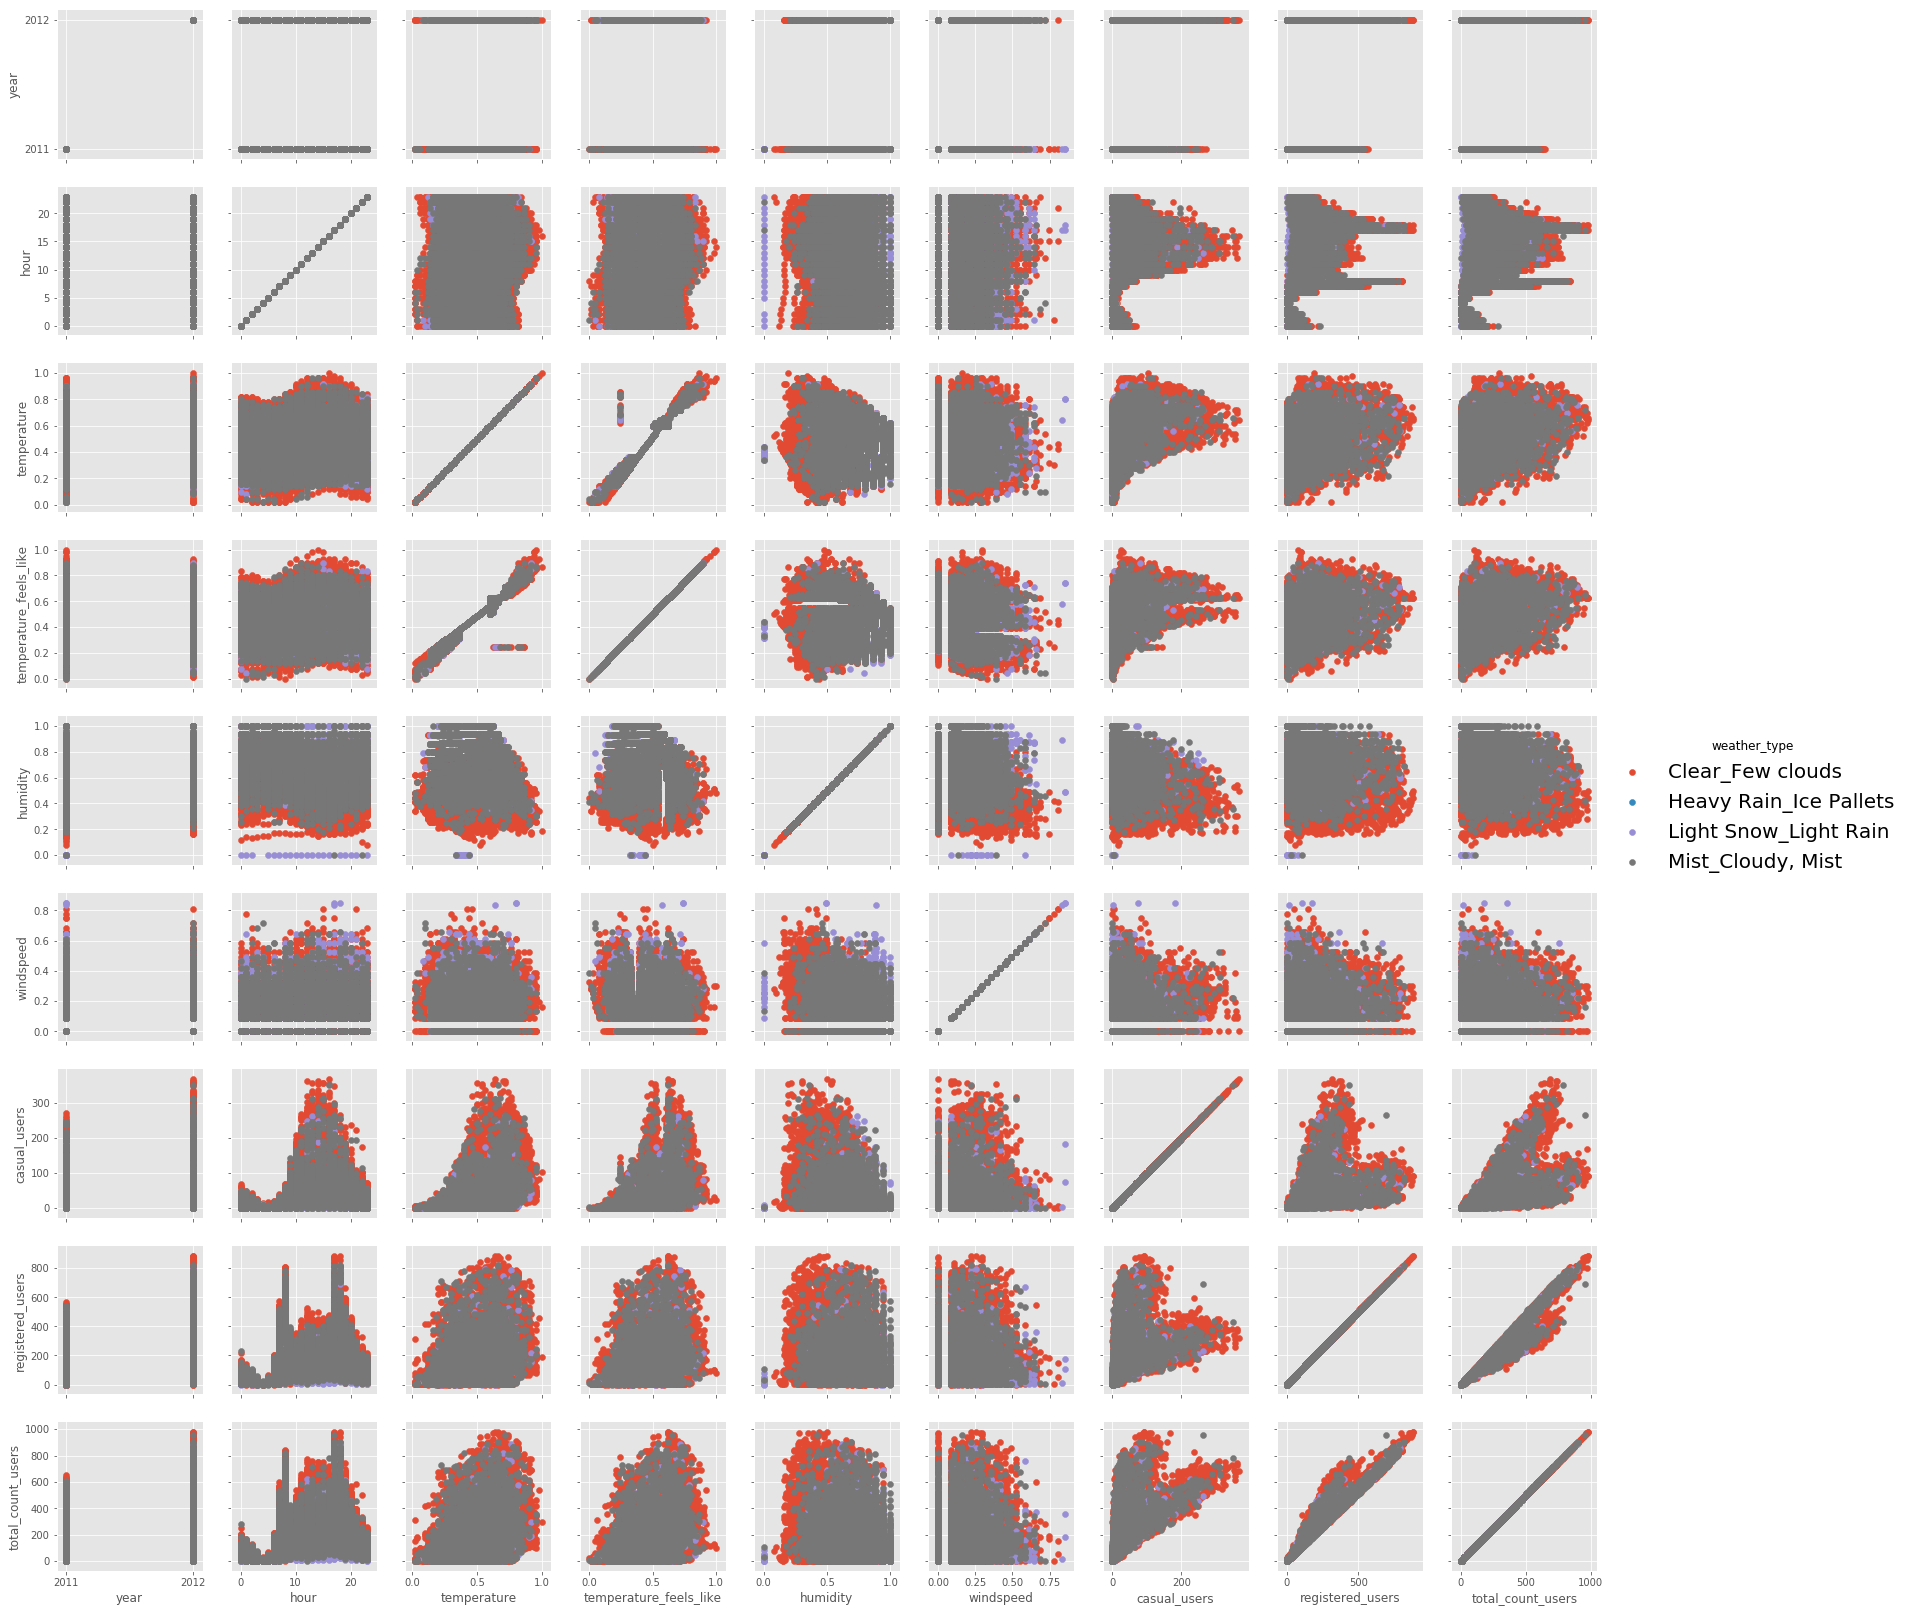

In [35]:
g = sns.PairGrid(data_hour, hue = "weather_type")
g.map(plt.scatter)
g = g.add_legend()

### Correlation Plot

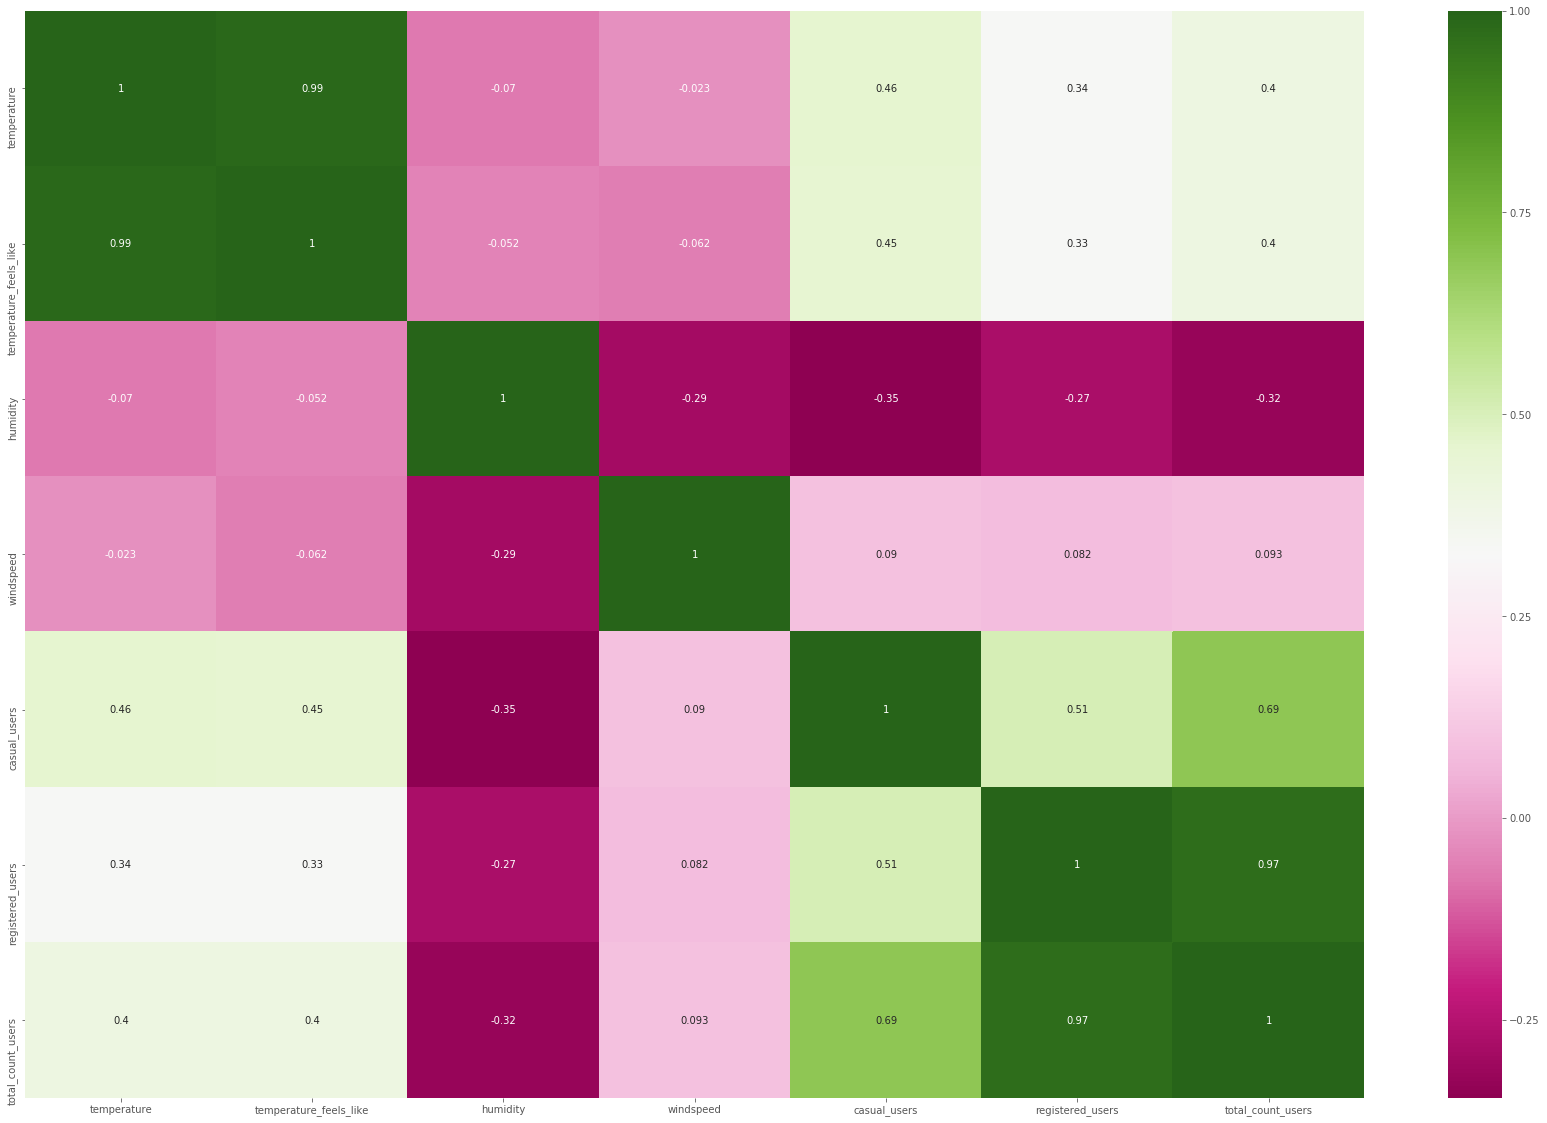

In [36]:
sns.heatmap(data_hour.corr(), cmap="PiYG", annot=True)

From the above correlation plot, we can observe that temperature and feels-like temperature are highly correlated. We can drop temperature and only take feels like temperature because that is what matters while biking.
As total count users = casual users + registered users, they're highly correlated with each other.

# Dummy Variables - Categorical Features

In [58]:
data_hour_dummies = pd.get_dummies(data_hour, columns=['season',
                                                      'year',
                                                      'month',
                                                      'hour',
                                                      'holiday',
                                                      'weekday',
                                                      'workingday',
                                                      'weather_type'],drop_first=True)

# Train-Test-Split Data for regression analysis

In [59]:
X = data_hour_dummies.drop(["temperature",
                           "casual_users",                 
                           "registered_users",
                           "total_count_users"], axis = 1)

y = data_day_dummies["total_count_users"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Regression Models

## Linear Regression using Scikit-Learn

In [60]:
model = LinearRegression()

model.fit(X_train, y_train)

y_hat = model.predict(X_test)

r2_score(y_test, y_hat)

0.683760088474642

In [61]:
import scipy
scipy.stats.pearsonr(y_test, y_hat)

(0.8271324762453314, 0.0)

## Random Forest Regressor

In [62]:
# Importing the random forest model
from sklearn.ensemble import RandomForestRegressor

# Evaluating model's area under curve ROC
from sklearn.metrics import r2_score, accuracy_score

In [63]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [64]:
print(rf.score(X_test, y_test))

y_pred = rf.predict(X_test)

0.9059632200583092


In [65]:
from sklearn import metrics
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred)) 

Mean Squared Error: 3024.0640697800795


In [66]:
scipy.stats.pearsonr(y_test, y_pred)

(0.9518968489065149, 0.0)

In [67]:
feature_importances = pd.DataFrame(rf.feature_importances_ ,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
temperature_feels_like,0.205956
workingday_working_day,0.096204
hour_17,0.095752
year_2012,0.078434
humidity,0.078313
hour_18,0.072890
hour_8,0.058612
hour_19,0.030444
hour_16,0.016776
hour_2,0.016116


Text(0, 0.5, 'Feature Importance')

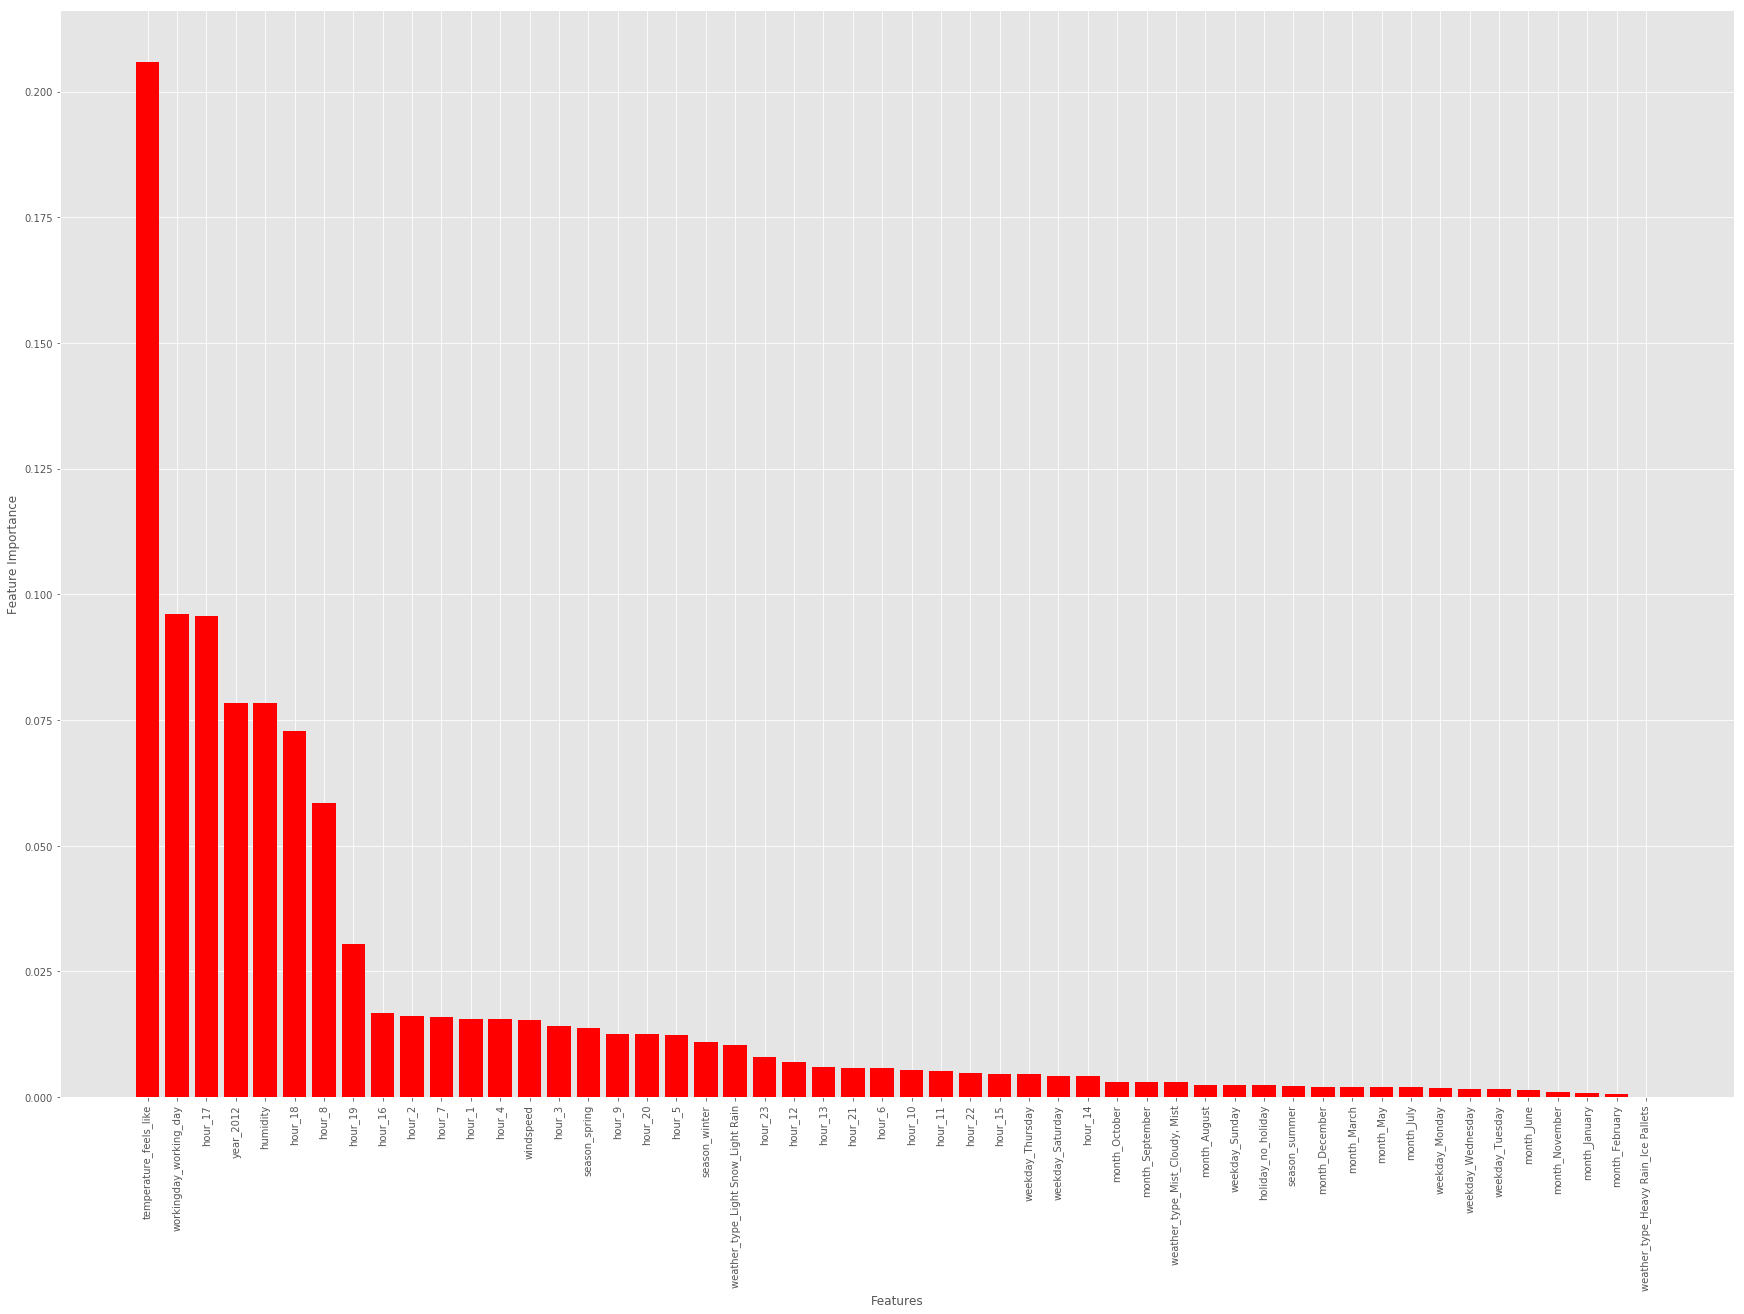

In [68]:
plt.bar(feature_importances.index, feature_importances.importance, color = "red")
plt.xlabel("Features")
plt.xticks(rotation=90)
plt.ylabel("Feature Importance") #redraw it as pi-chart and bar chart both

## Deep Neural Nets

In [69]:
# Keras and TensorFlow imports for Deep Learning
import keras
import tensorflow as tf

# Using keras with a Scikit-learn wrapper
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor

# for defining the Neural-net
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import Adam

In [70]:
def reg_model(learn_rate = 0.01):
    network = keras.models.Sequential()
    layer_1 = Dense(512, input_shape = (X_train.shape[1],), activation="relu")
    layer_2 = Dense(512, activation="relu")
    layer_3 = Dense(512, activation="relu")
    layer_4 = Dense(1)
    network.add(layer_1)
    network.add(Dropout(0.2))
    network.add(layer_2)
    network.add(Dropout(0.2))
    network.add(layer_3)
    network.add(Dropout(0.2))
    network.add(layer_4)
    network.compile(loss = "mean_squared_error",
                    optimizer = "adam",
                    metrics = ["mse"])
    return network

In [71]:
epochs = 300
batch_size = 32
mlpModel = KerasRegressor(reg_model, epochs=epochs, batch_size=batch_size, verbose=1)
mlpModel.fit(X_train, y_train)
yhat = mlpModel.predict(X_test)
rsquared  = r2_score(y_test, yhat)
mse = mean_squared_error(y_test, yhat)
print(f"Model coefficient of determination, R^2={rsquared}")
print(f"MSE: {mse}")

Epoch 1/300
13034/13034 [==============================] - 5s 387us/step - loss: 13377.7938 - mean_squared_error: 13377.7938
Epoch 2/300
13034/13034 [==============================] - 4s 293us/step - loss: 3617.6801 - mean_squared_error: 3617.6801
Epoch 3/300
13034/13034 [==============================] - 4s 319us/step - loss: 3099.5665 - mean_squared_error: 3099.5665
Epoch 4/300
13034/13034 [==============================] - 4s 310us/step - loss: 2795.3351 - mean_squared_error: 2795.3351
Epoch 5/300
13034/13034 [==============================] - 4s 324us/step - loss: 2726.6460 - mean_squared_error: 2726.6460
Epoch 6/300
13034/13034 [==============================] - 4s 325us/step - loss: 2597.7521 - mean_squared_error: 2597.7521
Epoch 7/300
13034/13034 [==============================] - 4s 335us/step - loss: 2397.7673 - mean_squared_error: 2397.7673
Epoch 8/300
13034/13034 [==============================] - 4s 334us/step - loss: 2419.5265 - mean_squared_error: 2419.5265
Epoch 9/300
13

13034/13034 [==============================] - 4s 303us/step - loss: 1145.1367 - mean_squared_error: 1145.1367
Epoch 68/300
13034/13034 [==============================] - 4s 303us/step - loss: 1155.9039 - mean_squared_error: 1155.9039
Epoch 69/300
13034/13034 [==============================] - 4s 304us/step - loss: 1109.1113 - mean_squared_error: 1109.1113
Epoch 70/300
13034/13034 [==============================] - 4s 308us/step - loss: 1178.1678 - mean_squared_error: 1178.1678
Epoch 71/300
13034/13034 [==============================] - 4s 316us/step - loss: 1189.7116 - mean_squared_error: 1189.7116
Epoch 72/300
13034/13034 [==============================] - 4s 303us/step - loss: 1115.7708 - mean_squared_error: 1115.7708
Epoch 73/300
13034/13034 [==============================] - 4s 308us/step - loss: 1151.5340 - mean_squared_error: 1151.5340
Epoch 74/300
13034/13034 [==============================] - 4s 301us/step - loss: 1126.4497 - mean_squared_error: 1126.4497
Epoch 75/300
13034/13

13034/13034 [==============================] - 4s 304us/step - loss: 850.2801 - mean_squared_error: 850.2801
Epoch 134/300
13034/13034 [==============================] - 73s 6ms/step - loss: 872.6298 - mean_squared_error: 872.6298
Epoch 135/300
13034/13034 [==============================] - 5s 409us/step - loss: 806.1433 - mean_squared_error: 806.1433
Epoch 136/300
13034/13034 [==============================] - 16s 1ms/step - loss: 843.9928 - mean_squared_error: 843.9928
Epoch 137/300
13034/13034 [==============================] - 16s 1ms/step - loss: 795.4699 - mean_squared_error: 795.4699
Epoch 138/300
13034/13034 [==============================] - 1782s 137ms/step - loss: 801.5551 - mean_squared_error: 801.5551
Epoch 139/300
13034/13034 [==============================] - 4s 306us/step - loss: 864.4645 - mean_squared_error: 864.4645
Epoch 140/300
13034/13034 [==============================] - 4s 287us/step - loss: 811.4854 - mean_squared_error: 811.4854
Epoch 141/300
13034/13034 [===

13034/13034 [==============================] - 4s 305us/step - loss: 694.9613 - mean_squared_error: 694.9613
Epoch 200/300
13034/13034 [==============================] - 4s 303us/step - loss: 653.9337 - mean_squared_error: 653.9337
Epoch 201/300
13034/13034 [==============================] - 4s 303us/step - loss: 665.8587 - mean_squared_error: 665.8587
Epoch 202/300
13034/13034 [==============================] - 4s 305us/step - loss: 720.2003 - mean_squared_error: 720.2003
Epoch 203/300
13034/13034 [==============================] - 4s 303us/step - loss: 703.1995 - mean_squared_error: 703.1995
Epoch 204/300
13034/13034 [==============================] - 4s 310us/step - loss: 692.4238 - mean_squared_error: 692.4238
Epoch 205/300
13034/13034 [==============================] - 4s 315us/step - loss: 706.2830 - mean_squared_error: 706.2830
Epoch 206/300
13034/13034 [==============================] - 4s 324us/step - loss: 689.6657 - mean_squared_error: 689.6657
Epoch 207/300
13034/13034 [===

13034/13034 [==============================] - 4s 309us/step - loss: 610.9304 - mean_squared_error: 610.9304
Epoch 266/300
13034/13034 [==============================] - 4s 309us/step - loss: 631.6994 - mean_squared_error: 631.6994
Epoch 267/300
13034/13034 [==============================] - 4s 303us/step - loss: 622.3647 - mean_squared_error: 622.3647
Epoch 268/300
13034/13034 [==============================] - 4s 303us/step - loss: 620.8239 - mean_squared_error: 620.8239
Epoch 269/300
13034/13034 [==============================] - 4s 303us/step - loss: 584.9548 - mean_squared_error: 584.9548
Epoch 270/300
13034/13034 [==============================] - 4s 303us/step - loss: 606.3414 - mean_squared_error: 606.3414
Epoch 271/300
13034/13034 [==============================] - 4s 302us/step - loss: 599.9092 - mean_squared_error: 599.9092
Epoch 272/300
13034/13034 [==============================] - 4s 303us/step - loss: 593.6104 - mean_squared_error: 593.6104
Epoch 273/300
13034/13034 [===

In [72]:
scipy.stats.pearsonr(y_test, yhat)

(0.9737714830597148, 0.0)